In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings

# ---------------------------
# 1. Load column names
# ---------------------------
def load_column_names(path):
    names = []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("Column"):
                col_name = line.split(" ", 2)[-1].split(";")[0].strip()
                names.append(col_name)
    return names

# ---------------------------
# 2. Parse label legend
# ---------------------------
def parse_label_legend(path):
    legend = {}
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("Unique"):
                continue
            parts = re.split(r"\s*-\s*", line)
            if len(parts) == 3:
                idx, track, label = parts
                idx = int(idx.strip())
                track = track.strip()
                label = label.strip()
                if track not in legend:
                    legend[track] = {}
                legend[track][idx] = label
    return legend

# ---------------------------
# 3. Load .dat file
# ---------------------------
def load_dat_file(file_path, col_names):
    df = pd.read_csv(file_path, delimiter=" ", header=None)
    df.columns = col_names[:df.shape[1]]
    return df

# ---------------------------
# 4. Split columns by modality
# ---------------------------
def split_modalities(df):
    modalities = {}
    acc_cols = [c for c in df.columns if "Accelerometer" in c]
    imu_cols = [c for c in df.columns if "InertialMeasurementUnit" in c]
    loc_cols = [c for c in df.columns if "LOCATION" in c]
    reed_cols = [c for c in df.columns if "REED SWITCH" in c]

    if acc_cols: modalities['accelerometers'] = df[acc_cols].values
    if imu_cols: modalities['IMU'] = df[imu_cols].values
    if loc_cols: modalities['locations'] = df[loc_cols].values
    if reed_cols: modalities['reed_switches'] = df[reed_cols].values

    return modalities

# ---------------------------
# 5. Sliding windows (multi-modal)
# ---------------------------
def create_windows_multimodal(modalities_dict, labels_dict, window_size=100, stride=50):
    X_modalities = {mod: [] for mod in modalities_dict.keys()}
    y = []
    n_samples = len(next(iter(modalities_dict.values())))
    label_keys = list(labels_dict.keys())
    
    for start in range(0, n_samples - window_size + 1, stride):
        end = start + window_size
        for mod, data in modalities_dict.items():
            X_modalities[mod].append(data[start:end])
        # Assign label at window end
        y.append([labels_dict[k][end-1] for k in label_keys])

    X_modalities = {mod: np.array(arr) for mod, arr in X_modalities.items()}
    y = np.array(y)
    return X_modalities, y

# ---------------------------
# 6. Decode numeric labels (robust)
# ---------------------------
def decode_labels_numeric(y_array, legend, label_keys):
    decoded = []
    for row in y_array:
        row_dict = {}
        for key, val in zip(label_keys, row):
            track_dict = legend.get(key)
            if isinstance(track_dict, dict):
                row_dict[key] = track_dict.get(int(val), "Unknown")
            else:
                row_dict[key] = "Unknown"
        decoded.append(row_dict)
    return decoded

# ---------------------------
# 7. Filter rare classes
# ---------------------------
def filter_rare_classes(y_array, label_tracks, min_samples=10):
    """
    Filter out classes that have fewer than min_samples
    """
    y_filtered = y_array.copy()
    
    for i, task in enumerate(label_tracks):
        counts = Counter(y_array[:, i])
        rare_classes = [cls for cls, count in counts.items() if count < min_samples]
        
        if rare_classes:
            print(f"Filtering rare classes in {task}: {rare_classes}")
            # Replace rare classes with 0 (Unknown/Other)
            mask = np.isin(y_filtered[:, i], rare_classes)
            y_filtered[mask, i] = 0
    
    return y_filtered

# ---------------------------
# 8. Improved stratified split for multi-label
# ---------------------------
def stratified_multilabel_split(X_dict, y_array, test_size=0.3, random_state=42):
    """
    Create a more balanced split for multi-label data by considering
    the most important/balanced label for stratification
    """
    n_samples = y_array.shape[0]
    
    # Find the label column with best balance for stratification
    best_col = 0
    best_entropy = 0
    
    for i in range(y_array.shape[1]):
        counts = Counter(y_array[:, i])
        # Calculate normalized entropy as a measure of balance
        total = sum(counts.values())
        probs = [count/total for count in counts.values()]
        entropy = -sum(p * np.log2(p + 1e-10) for p in probs)
        normalized_entropy = entropy / np.log2(len(counts))
        
        if normalized_entropy > best_entropy:
            best_entropy = normalized_entropy
            best_col = i
    
    print(f"Using column {best_col} for stratification (entropy: {best_entropy:.3f})")
    
    # Create stratified split
    indices = np.arange(n_samples)
    try:
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size, 
            random_state=random_state,
            stratify=y_array[:, best_col]
        )
    except ValueError as e:
        print(f"Stratification failed: {e}")
        print("Falling back to random split...")
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size, 
            random_state=random_state
        )
    
    # Split the data
    X_train = {mod: X_dict[mod][train_idx] for mod in X_dict}
    X_test = {mod: X_dict[mod][test_idx] for mod in X_dict}
    y_train = y_array[train_idx]
    y_test = y_array[test_idx]
    
    return X_train, X_test, y_train, y_test

# ---------------------------
# 9. Check class distribution balance
# ---------------------------
def check_class_balance(y_train, y_test, label_tracks):
    """
    Check if classes are reasonably balanced between train and test sets
    """
    print("\n=== Class Distribution Check ===")
    
    for i, task in enumerate(label_tracks):
        train_counts = Counter(y_train[:, i])
        test_counts = Counter(y_test[:, i])
        
        all_classes = set(train_counts.keys()) | set(test_counts.keys())
        train_only = set(train_counts.keys()) - set(test_counts.keys())
        test_only = set(test_counts.keys()) - set(train_counts.keys())
        
        print(f"\n--- {task} ---")
        print(f"Total unique classes: {len(all_classes)}")
        print(f"Classes only in train: {len(train_only)} {list(train_only) if train_only else ''}")
        print(f"Classes only in test: {len(test_only)} {list(test_only) if test_only else ''}")
        
        # Show distribution for common classes
        common_classes = set(train_counts.keys()) & set(test_counts.keys())
        print(f"Classes in both: {len(common_classes)}")

# ---------------------------
# 10. Full preprocessing with improved splitting
# ---------------------------
def preprocess_opportunity_multimodal_balanced(dataset_folder,
                                               target_labels=None,
                                               window_size=100,
                                               stride=50,
                                               test_size=0.3,
                                               random_state=42,
                                               min_samples_per_class=10,
                                               filter_rare=True):
    if target_labels is None:
        target_labels = [
            "Locomotion", "HL_Activity", "LL_Left_Arm",
            "LL_Left_Arm_Object", "LL_Right_Arm",
            "LL_Right_Arm_Object", "ML_Both_Arms"
        ]

    col_names = load_column_names(os.path.join(dataset_folder, "column_names.txt"))
    legend = parse_label_legend(os.path.join(dataset_folder, "label_legend.txt"))

    X_mod_windows = {mod: [] for mod in ['accelerometers','IMU','locations','reed_switches']}
    y_windows = []

    files = [f for f in os.listdir(dataset_folder) if f.endswith(".dat")]
    
    for fname in files:
        df = load_dat_file(os.path.join(dataset_folder, fname), col_names)
        modalities = split_modalities(df)
        labels_dict = {track: df[track].values for track in target_labels}

        # Replace NaNs/Infs and scale
        for mod, arr in modalities.items():
            arr = np.nan_to_num(arr)
            modalities[mod] = StandardScaler().fit_transform(arr)

        # Sliding windows
        X_w, y_w = create_windows_multimodal(modalities, labels_dict, window_size, stride)
        for mod in X_w:
            X_mod_windows[mod].append(X_w[mod])
        y_windows.append(y_w)

    # Concatenate windows per modality
    X_mod_windows = {mod: np.concatenate(arr_list, axis=0) 
                     for mod, arr_list in X_mod_windows.items() if arr_list}
    y_windows = np.concatenate(y_windows, axis=0)

    print(f"Original data shape: {y_windows.shape}")
    
    # Filter rare classes if requested
    if filter_rare:
        y_windows = filter_rare_classes(y_windows, target_labels, min_samples_per_class)

    # Improved train/test split
    X_train_mod, X_test_mod, y_train, y_test = stratified_multilabel_split(
        X_mod_windows, y_windows, test_size, random_state
    )

    # Check class balance
    check_class_balance(y_train, y_test, target_labels)

    # Decode a few labels for verification
    decoded_example = decode_labels_numeric(y_train[:5], legend, target_labels)
    print(f"\nDecoded labels (sample): {decoded_example}")

    return (X_train_mod, y_train), (X_test_mod, y_test), legend, target_labels

# ---------------------------
# 11. Utility function to get balanced label distributions
# ---------------------------
def get_label_distributions_comparison(y_train, y_test, label_tracks):
    """
    Compare label distributions between train and test sets
    """
    print("\n=== Label Distribution Comparison ===")
    
    for i, task in enumerate(label_tracks):
        print(f"\n--- {task} ---")
        
        train_counts = Counter(y_train[:, i])
        test_counts = Counter(y_test[:, i])
        
        all_classes = sorted(set(train_counts.keys()) | set(test_counts.keys()))
        
        print(f"{'Class':<8} {'Train Count':<12} {'Train %':<10} {'Test Count':<11} {'Test %':<10}")
        print("-" * 60)
        
        train_total = len(y_train)
        test_total = len(y_test)
        
        for cls in all_classes:
            train_count = train_counts.get(cls, 0)
            test_count = test_counts.get(cls, 0)
            train_pct = (train_count / train_total) * 100
            test_pct = (test_count / test_total) * 100
            
            print(f"{cls:<8} {train_count:<12} {train_pct:<10.2f} {test_count:<11} {test_pct:<10.2f}")

# ---------------------------
# Example usage
# ---------------------------
# Usage example for your main code
if __name__ == "__main__":
    dataset_folder = "/kaggle/input/opportunity-activity-recognition/OpportunityUCIDataset/dataset"
    (train_X_mod, train_y), (test_X_mod, test_y), legend, label_tracks = preprocess_opportunity_multimodal_balanced(
        dataset_folder=dataset_folder,
        window_size=100,
        stride=50,
        test_size=0.3,
        min_samples_per_class=100,
        filter_rare=True
    )
    
    # Summary
    print(f"\nLabel tracks: {label_tracks}")
    for mod in train_X_mod:
        print(f"Train {mod}: {train_X_mod[mod].shape}")
    print(f"Train labels: {train_y.shape}")
    print(f"Test labels: {test_y.shape}")
    
    # Show detailed comparison
    get_label_distributions_comparison(train_y, test_y, label_tracks)

Original data shape: (17350, 7)
Filtering rare classes in LL_Left_Arm: [201, 203, 209, 208, 207, 210]
Filtering rare classes in LL_Left_Arm_Object: [319, 311, 308, 316, 307, 306, 310, 312, 322, 309, 323, 315, 317]
Filtering rare classes in LL_Right_Arm: [401, 403, 402, 409]
Filtering rare classes in LL_Right_Arm_Object: [515, 523]
Using column 1 for stratification (entropy: 0.890)

=== Class Distribution Check ===

--- Locomotion ---
Total unique classes: 5
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 5

--- HL_Activity ---
Total unique classes: 6
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 6

--- LL_Left_Arm ---
Total unique classes: 6
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 6

--- LL_Left_Arm_Object ---
Total unique classes: 11
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 11

--- LL_Right_Arm ---
Total unique classes: 10
Classes only in train: 0 
Classes only in test: 0 
Classes in both:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import psutil
import time
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
from abc import ABC, abstractmethod
import numpy as np

# ---------------------------
# Resource Monitor (Shared with LightSpaN)
# ---------------------------
@dataclass
class ResourceMetrics:
    cpu_percent: float
    memory_percent: float
    inference_latency: float
    power_level: float  # 0.0-1.0 (estimated battery level for mobile devices)
    temperature: Optional[float] = None

class ResourceMonitor:
    def __init__(self, history_size=10):
        self.history_size = history_size
        self.latency_history = []
        self.cpu_history = []
        self.memory_history = []
    
    def get_current_metrics(self) -> ResourceMetrics:
        cpu_percent = psutil.cpu_percent(interval=0.1)
        memory = psutil.virtual_memory()
        
        # Estimate power level (in real IoT device, this would come from battery API)
        power_level = max(0.1, 1.0 - (cpu_percent / 100.0) * 0.5)
        
        # Calculate average latency from history
        avg_latency = sum(self.latency_history[-5:]) / max(1, len(self.latency_history[-5:]))
        
        return ResourceMetrics(
            cpu_percent=cpu_percent,
            memory_percent=memory.percent,
            inference_latency=avg_latency,
            power_level=power_level
        )
    
    def update_latency(self, latency: float):
        self.latency_history.append(latency)
        if len(self.latency_history) > self.history_size:
            self.latency_history.pop(0)

# ---------------------------
# Adaptive Model Complexity Controller
# ---------------------------
class ComplexityController:
    def __init__(self, min_complexity=0.2, max_complexity=1.0, target_latency_ms=100):
        self.min_complexity = min_complexity
        self.max_complexity = max_complexity
        self.target_latency_ms = target_latency_ms
        self.current_complexity = 0.7
        self.adaptation_rate = 0.15
        
    def calculate_target_complexity(self, metrics: ResourceMetrics) -> float:
        """Calculate target model complexity based on current resource constraints"""
        
        # Resource pressure factors (opposite of LightSpaN's sparsity)
        cpu_factor = 1.0 - min(1.0, metrics.cpu_percent / 80.0)  # High CPU reduces complexity
        memory_factor = 1.0 - min(1.0, metrics.memory_percent / 85.0)  # High memory reduces complexity
        latency_factor = max(0.3, 1.0 - (metrics.inference_latency / self.target_latency_ms))  # High latency reduces complexity
        power_factor = metrics.power_level  # Low power reduces complexity
        
        # Weighted combination
        resource_availability = (
            0.3 * cpu_factor + 
            0.2 * memory_factor + 
            0.3 * latency_factor + 
            0.2 * power_factor
        )
        
        # Map to complexity range
        target_complexity = self.min_complexity + (self.max_complexity - self.min_complexity) * resource_availability
        
        # Smooth adaptation
        self.current_complexity += self.adaptation_rate * (target_complexity - self.current_complexity)
        self.current_complexity = max(self.min_complexity, min(self.max_complexity, self.current_complexity))
        
        return self.current_complexity

# ---------------------------
# Low-Rank Decomposed Linear Layer
# ---------------------------
class LowRankLinear(nn.Module):
    def __init__(self, in_features, out_features, rank_ratio=0.5, enable_adaptation=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.enable_adaptation = enable_adaptation
        self.max_rank = min(in_features, out_features)
        self.current_rank = max(1, int(self.max_rank * rank_ratio))
        
        # Low-rank decomposition: W = U @ V^T
        self.U = nn.Parameter(torch.randn(out_features, self.max_rank) * 0.1)
        self.V = nn.Parameter(torch.randn(in_features, self.max_rank) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_features))
        
        # Importance scores for rank adaptation
        self.register_buffer("rank_importance", torch.ones(self.max_rank))
        
    def update_rank(self, complexity_factor):
        """Update effective rank based on complexity factor"""
        if not self.enable_adaptation:
            return
            
        target_rank = max(1, int(self.max_rank * complexity_factor))
        self.current_rank = target_rank
    
    def forward(self, x):
        # Use only the top-k most important rank components
        U_active = self.U[:, :self.current_rank]
        V_active = self.V[:, :self.current_rank]
        
        # Reconstruct weight matrix for active ranks
        weight = U_active @ V_active.t()
        return F.linear(x, weight, self.bias)
    
    def update_rank_importance(self, gradients=None):
        """Update rank importance based on gradient information"""
        if gradients is not None and self.enable_adaptation:
            # Calculate importance based on gradient magnitude
            grad_U = gradients.get('U', torch.zeros_like(self.U))
            grad_V = gradients.get('V', torch.zeros_like(self.V))
            
            rank_importance = torch.norm(grad_U, dim=0) + torch.norm(grad_V, dim=0)
            
            # Exponential moving average
            alpha = 0.9
            self.rank_importance = alpha * self.rank_importance + (1 - alpha) * rank_importance

# ---------------------------
# Depthwise Separable Convolution
# ---------------------------
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1)
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.activation = nn.ReLU6()
    
    def forward(self, x):
        x = self.activation(self.bn1(self.depthwise(x)))
        x = self.activation(self.bn2(self.pointwise(x)))
        return x

# ---------------------------
# Adaptive Feature Extractor
# ---------------------------
class AdaptiveFeatureExtractor(nn.Module):
    def __init__(self, input_dim, base_channels=32, output_dim=64, complexity_levels=3):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.complexity_levels = complexity_levels
        self.current_level = 2  # Start with medium complexity
        
        # Multi-level feature extraction (from simple to complex)
        self.level_1 = nn.Sequential(
            nn.Linear(input_dim, output_dim // 2),
            nn.ReLU(),
            nn.Linear(output_dim // 2, output_dim)
        )
        
        if input_dim > 16:  # Use conv for multi-dimensional inputs
            self.level_2 = nn.Sequential(
                DepthwiseSeparableConv1d(1, base_channels, 3, padding=1),
                nn.AdaptiveAvgPool1d(output_dim // 4),
                nn.Flatten(),
                LowRankLinear(base_channels * (output_dim // 4), output_dim, rank_ratio=0.6)
            )
            
            self.level_3 = nn.Sequential(
                DepthwiseSeparableConv1d(1, base_channels, 3, padding=1),
                DepthwiseSeparableConv1d(base_channels, base_channels * 2, 3, padding=1),
                nn.AdaptiveAvgPool1d(output_dim // 8),
                nn.Flatten(),
                LowRankLinear(base_channels * 2 * (output_dim // 8), output_dim, rank_ratio=0.8),
                nn.Dropout(0.1)
            )
        else:  # Use only linear layers for low-dimensional inputs
            self.level_2 = nn.Sequential(
                LowRankLinear(input_dim, output_dim, rank_ratio=0.6),
                nn.ReLU(),
                LowRankLinear(output_dim, output_dim, rank_ratio=0.5)
            )
            
            self.level_3 = nn.Sequential(
                LowRankLinear(input_dim, output_dim * 2, rank_ratio=0.8),
                nn.ReLU(),
                LowRankLinear(output_dim * 2, output_dim, rank_ratio=0.7),
                nn.Dropout(0.1)
            )
    
    def update_complexity(self, complexity_factor):
        """Update active complexity level and internal parameters"""
        if complexity_factor < 0.4:
            self.current_level = 1
        elif complexity_factor < 0.8:
            self.current_level = 2
        else:
            self.current_level = 3
        
        # Update low-rank layers
        for module in self.modules():
            if isinstance(module, LowRankLinear):
                module.update_rank(complexity_factor)
    
    def forward(self, x):
        if len(x.shape) == 2:  # (batch, features)
            if hasattr(self, 'level_2') and self.input_dim > 16 and self.current_level >= 2:
                # Add channel dimension for conv layers
                x_conv = x.unsqueeze(1)  # (batch, 1, features)
        
        if self.current_level == 1:
            return self.level_1(x)
        elif self.current_level == 2:
            if self.input_dim > 16:
                return self.level_2(x_conv)
            else:
                return self.level_2(x)
        else:  # level 3
            if self.input_dim > 16:
                return self.level_3(x_conv)
            else:
                return self.level_3(x)

# ---------------------------
# Feature Fusion Module
# ---------------------------
class ModalityFusion(nn.Module):
    def __init__(self, feature_dim, num_modalities, fusion_type="weighted_sum"):
        super().__init__()
        self.feature_dim = feature_dim
        self.num_modalities = num_modalities
        self.fusion_type = fusion_type
        
        if fusion_type == "weighted_sum":
            self.weights = nn.Parameter(torch.ones(num_modalities) / num_modalities)
        elif fusion_type == "mlp":
            self.fusion_mlp = LowRankLinear(feature_dim * num_modalities, feature_dim, rank_ratio=0.6)
        elif fusion_type == "attention":
            self.attention = LowRankLinear(feature_dim, 1, rank_ratio=0.4)
        
        self.layer_norm = nn.LayerNorm(feature_dim)
    
    def update_complexity(self, complexity_factor):
        """Update fusion complexity"""
        if hasattr(self, 'fusion_mlp'):
            self.fusion_mlp.update_rank(complexity_factor)
        if hasattr(self, 'attention'):
            self.attention.update_rank(complexity_factor)
    
    def forward(self, features: List[torch.Tensor]):
        if len(features) == 1:
            return self.layer_norm(features[0])
        
        stacked = torch.stack(features, dim=1)  # (batch, num_modalities, feature_dim)
        
        if self.fusion_type == "weighted_sum":
            # Apply learned weights
            weights = F.softmax(self.weights, dim=0)
            fused = torch.sum(stacked * weights.view(1, -1, 1), dim=1)
        
        elif self.fusion_type == "mlp":
            # Concatenate and pass through MLP
            concat = stacked.view(stacked.size(0), -1)
            fused = self.fusion_mlp(concat)
        
        elif self.fusion_type == "attention":
            # Attention-based fusion
            attn_scores = self.attention(stacked).squeeze(-1)  # (batch, num_modalities)
            attn_weights = F.softmax(attn_scores, dim=1)
            fused = torch.sum(stacked * attn_weights.unsqueeze(-1), dim=1)
        
        return self.layer_norm(fused)

# ---------------------------
# Transfer Learning Head
# ---------------------------
class TransferLearningHead(nn.Module):
    def __init__(self, input_dim, task_configs: Dict[str, int], hidden_dim=32):
        super().__init__()
        self.task_configs = task_configs
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Shared feature transformation
        self.shared_transform = LowRankLinear(input_dim, hidden_dim, rank_ratio=0.7)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
        # Task-specific heads
        self.task_heads = nn.ModuleDict()
        for task_name, num_classes in task_configs.items():
            self.task_heads[task_name] = LowRankLinear(hidden_dim, num_classes, rank_ratio=0.5)
        
        # Task importance and selection
        self.register_buffer("task_importance", torch.ones(len(task_configs)))
        self.active_tasks = list(task_configs.keys())
        
        # Continual learning buffers
        self.register_buffer("task_gradients", torch.zeros(len(task_configs), hidden_dim))
        
    def update_complexity(self, complexity_factor):
        """Update complexity of all components"""
        self.shared_transform.update_rank(complexity_factor)
        
        for head in self.task_heads.values():
            head.update_rank(complexity_factor * 0.7)  # Heads can be more compressed
        
        # Adaptive task selection under resource pressure
        if complexity_factor < 0.4:
            # Keep only the most important task
            most_important_idx = torch.argmax(self.task_importance).item()
            self.active_tasks = [list(self.task_configs.keys())[most_important_idx]]
        elif complexity_factor < 0.7:
            # Keep top 2 tasks
            top_indices = torch.topk(self.task_importance, min(2, len(self.task_configs))).indices
            self.active_tasks = [list(self.task_configs.keys())[i] for i in top_indices]
        else:
            # Keep all tasks
            self.active_tasks = list(self.task_configs.keys())
    
    def forward(self, x):
        # Shared transformation
        shared_features = self.dropout(self.activation(self.shared_transform(x)))
        
        # Task-specific predictions (only for active tasks)
        outputs = {}
        for task_name in self.active_tasks:
            outputs[task_name] = self.task_heads[task_name](shared_features)
        
        return outputs
    
    def update_task_importance(self, task_losses: Dict[str, float]):
        """Update task importance based on recent losses"""
        for i, (task_name, loss) in enumerate(task_losses.items()):
            if i < len(self.task_importance):
                # Higher loss = higher importance (needs more attention)
                self.task_importance[i] = 0.9 * self.task_importance[i] + 0.1 * loss

# ---------------------------
# Main TinyTL Model
# ---------------------------
class TinyTL(nn.Module):
    def __init__(self, 
                 modality_configs: Dict[str, int], 
                 task_configs: Dict[str, int],
                 base_feature_dim=64,
                 target_latency_ms=100,
                 fusion_type="weighted_sum"):
        super().__init__()
        
        # Resource management
        self.resource_monitor = ResourceMonitor()
        self.complexity_controller = ComplexityController(
            min_complexity=0.2, max_complexity=1.0, target_latency_ms=target_latency_ms
        )
        
        # Feature extractors for each modality
        self.extractors = nn.ModuleDict({
            mod_name: AdaptiveFeatureExtractor(
                input_dim=input_dim,
                base_channels=min(32, max(8, input_dim // 4)),
                output_dim=base_feature_dim,
                complexity_levels=3
            )
            for mod_name, input_dim in modality_configs.items()
        })
        
        # Feature fusion
        self.fusion = ModalityFusion(
            feature_dim=base_feature_dim,
            num_modalities=len(modality_configs),
            fusion_type=fusion_type
        )
        
        # Transfer learning classifier
        self.classifier = TransferLearningHead(
            input_dim=base_feature_dim,
            task_configs=task_configs,
            hidden_dim=min(64, base_feature_dim)
        )
        
        # Batch normalization
        self.feature_norm = nn.BatchNorm1d(base_feature_dim)
        
        # Adaptation tracking
        self.adaptation_counter = 0
        self.adapt_every_n_inferences = 8  # More frequent adaptation than LightSpaN
        self.modality_configs = modality_configs
        
        # Enable debug logging
        self._debug = False
    
    def adapt_complexity(self):
        """Adapt model complexity based on current resource constraints"""
        metrics = self.resource_monitor.get_current_metrics()
        target_complexity = self.complexity_controller.calculate_target_complexity(metrics)
        
        # Update all components
        for extractor in self.extractors.values():
            extractor.update_complexity(target_complexity)
        
        self.fusion.update_complexity(target_complexity)
        self.classifier.update_complexity(target_complexity)
        
        return target_complexity, metrics
    
    def forward(self, modality_data: Dict[str, torch.Tensor]):
        start_time = time.time()
        
        # Extract features from each modality
        features = []
        for mod_name, data in modality_data.items():
            if mod_name in self.extractors:
                if len(data.shape) == 3 and data.shape[1] > 1:
                    # Handle sequence data by taking mean
                    data = data.mean(dim=1)
                features.append(self.extractors[mod_name](data))
        
        if not features:
            # Fallback if no valid modalities
            batch_size = next(iter(modality_data.values())).size(0)
            device = next(self.parameters()).device
            features = [torch.zeros(batch_size, 64).to(device)]
        
        # Fuse features
        fused_features = self.fusion(features)
        fused_features = self.feature_norm(fused_features)
        
        # Classify
        outputs = self.classifier(fused_features)
        
        # Update latency tracking
        inference_time = (time.time() - start_time) * 1000  # ms
        self.resource_monitor.update_latency(inference_time)
        
        # Periodic adaptation
        self.adaptation_counter += 1
        if self.adaptation_counter >= self.adapt_every_n_inferences:
            target_complexity, metrics = self.adapt_complexity()
            self.adaptation_counter = 0
            
            if self._debug:
                print(f"TinyTL adapted complexity to {target_complexity:.3f}, "
                      f"CPU: {metrics.cpu_percent:.1f}%, "
                      f"Latency: {metrics.inference_latency:.1f}ms, "
                      f"Active tasks: {len(self.classifier.active_tasks)}")
        
        return outputs
    
    def resize_output_layers(self, new_task_configs: Dict[str, int]):
        """Dynamically resize classification heads for new classes"""
        print(f"TinyTL: Resizing output layers from {self.classifier.task_configs} to {new_task_configs}")
        
        for task_name, new_num_classes in new_task_configs.items():
            if task_name in self.classifier.task_configs:
                current_num_classes = self.classifier.task_configs[task_name]
                
                if new_num_classes > current_num_classes:
                    # Expand existing head
                    old_head = self.classifier.task_heads[task_name]
                    hidden_dim = old_head.in_features
                    
                    # Create new head with expanded output
                    new_head = LowRankLinear(hidden_dim, new_num_classes, 
                                           rank_ratio=old_head.current_rank / old_head.max_rank)
                    
                    # Transfer weights
                    with torch.no_grad():
                        # Copy U matrix (output side)
                        new_head.U.data[:current_num_classes, :old_head.current_rank] = \
                            old_head.U.data[:current_num_classes, :old_head.current_rank]
                        # Copy V matrix (input side) - fully copy since input dimension doesn't change
                        new_head.V.data[:, :old_head.current_rank] = old_head.V.data[:, :old_head.current_rank]
                        # Copy bias
                        new_head.bias.data[:current_num_classes] = old_head.bias.data
                        
                        # Initialize new parameters with smaller values
                        new_head.U.data[current_num_classes:] *= 0.1
                        new_head.bias.data[current_num_classes:] = 0
                    
                    self.classifier.task_heads[task_name] = new_head
                    print(f"  Expanded {task_name} from {current_num_classes} to {new_num_classes} classes")
                
            else:
                # New task
                hidden_dim = self.classifier.hidden_dim
                self.classifier.task_heads[task_name] = LowRankLinear(hidden_dim, new_num_classes, rank_ratio=0.5)
                print(f"  Added new task {task_name} with {new_num_classes} classes")
        
        # Update configs and importance
        self.classifier.task_configs = new_task_configs.copy()
        self.classifier.register_buffer("task_importance", torch.ones(len(new_task_configs)))
        self.classifier.active_tasks = list(new_task_configs.keys())
        
        print("TinyTL output layer resizing complete")
    
    def auto_detect_and_resize_classes(self, train_labels: Dict[str, torch.Tensor], use_class_count=True):
        """Auto-detect classes and resize (similar to LightSpaN)"""
        detected_classes = {}
        
        for task_name, labels in train_labels.items():
            unique_classes = torch.unique(labels[labels >= 0])
            max_class = int(unique_classes.max().item())
            
            if use_class_count:
                num_classes = len(unique_classes)
                print(f"TinyTL Task '{task_name}': {len(unique_classes)} classes, max ID: {max_class}")
            else:
                num_classes = max_class + 1
                print(f"TinyTL Task '{task_name}': Using {num_classes} outputs (max_id + 1)")
            
            detected_classes[task_name] = num_classes
        
        # Store class mappings
        self.class_mappings = {}
        for task_name, labels in train_labels.items():
            unique_classes = torch.unique(labels[labels >= 0])
            self.class_mappings[task_name] = {
                int(class_id.item()): idx for idx, class_id in enumerate(unique_classes)
            }
        
        if detected_classes != self.classifier.task_configs:
            self.resize_output_layers(detected_classes)
        
        return detected_classes
    
    def map_labels_to_indices(self, labels: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Map class IDs to indices"""
        if not hasattr(self, 'class_mappings'):
            raise ValueError("Class mappings not found. Run auto_detect_and_resize_classes() first.")
        
        mapped_labels = {}
        for task_name, task_labels in labels.items():
            if task_name not in self.class_mappings:
                mapped_labels[task_name] = task_labels
                continue
            
            mapping = self.class_mappings[task_name]
            mapped_task_labels = task_labels.clone()
            
            for original_id, new_index in mapping.items():
                mask = (task_labels == original_id)
                mapped_task_labels[mask] = new_index
            
            mapped_labels[task_name] = mapped_task_labels
        
        return mapped_labels
    
    def map_predictions_to_class_ids(self, predictions: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Map prediction indices back to class IDs"""
        if not hasattr(self, 'class_mappings'):
            return predictions
        
        mapped_predictions = {}
        for task_name, task_preds in predictions.items():
            if task_name not in self.class_mappings:
                mapped_predictions[task_name] = task_preds
                continue
            
            mapping = self.class_mappings[task_name]
            reverse_mapping = {idx: original_id for original_id, idx in mapping.items()}
            
            mapped_task_preds = task_preds.clone()
            for index, original_id in reverse_mapping.items():
                mask = (task_preds == index)
                mapped_task_preds[mask] = original_id
            
            mapped_predictions[task_name] = mapped_task_preds
        
        return mapped_predictions
    
    def get_model_stats(self):
        """Get current model efficiency statistics"""
        total_params = sum(p.numel() for p in self.parameters())
        
        # Count effective parameters in low-rank layers
        effective_params = 0
        total_ranks = 0
        
        for module in self.modules():
            if isinstance(module, LowRankLinear):
                # Low-rank parameters: U[:, :current_rank] + V[:, :current_rank] + bias
                u_params = module.out_features * module.current_rank
                v_params = module.in_features * module.current_rank  
                bias_params = module.out_features
                effective_params += u_params + v_params + bias_params
                total_ranks += module.current_rank
        
        compression_ratio = effective_params / max(1, total_params)
        
        stats = {
            'total_params': total_params,
            'effective_params': effective_params,
            'compression_ratio': compression_ratio,
            'current_complexity': self.complexity_controller.current_complexity,
            'total_active_ranks': total_ranks,
            'active_tasks': len(self.classifier.active_tasks),
            'task_configs': self.classifier.task_configs.copy(),
            'fusion_type': self.fusion.fusion_type
        }
        
        if hasattr(self, 'class_mappings'):
            stats['class_mappings'] = self.class_mappings.copy()
        
        return stats
    
    def enable_debug(self, enable=True):
        """Enable/disable debug logging"""
        self._debug = enable

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import psutil
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import time
from collections import deque, defaultdict
import copy

# ---------------------------
# TinyTL-Specific Live Streaming Dataset
# ---------------------------
import torch
import numpy as np
from collections import deque, defaultdict


class TinyTLStreamingDataset:
    def __init__(self, X_mod, y_dict, window_size=100, batch_size=32, 
                 stream_rate=10, noise_factor=0.1, complexity_aware=True,
                 balance_buffer=True, adaptive_noise=True, 
                 shuffle_data=True, shuffle_seed=None):
        """
        Streaming dataset optimized for TinyTL with LightSpaN-style class balancing
        
        Args:
            X_mod: Dictionary of modality data {modality_name: numpy_array}
            y_dict: Dictionary of task labels {task_name: tensor/array}
            window_size: Size of sliding window for streaming
            batch_size: Batch size for training
            stream_rate: Number of samples to stream per step
            noise_factor: Noise level for data augmentation (0.1 for LightSpaN)
            complexity_aware: Whether to adjust streaming rate based on model complexity
            balance_buffer: Enable class-balanced buffer insertion (LightSpaN feature)
            adaptive_noise: Use adaptive noise based on class frequency (LightSpaN feature)
            shuffle_data: Whether to shuffle data initially
            shuffle_seed: Random seed for shuffling (None = random, int = fixed)
        """
        self.X_mod = X_mod
        self.y_dict = y_dict
        self.window_size = window_size
        self.batch_size = batch_size
        self.stream_rate = stream_rate
        self.noise_factor = noise_factor
        self.complexity_aware = complexity_aware
        self.balance_buffer = balance_buffer
        self.adaptive_noise = adaptive_noise
        
        # Ensure all tasks have same number of samples
        self.n_samples = min(len(labels) for labels in y_dict.values())
        
        # Shuffle indices for realistic streaming (with optional seed control)
        if shuffle_data:
            if shuffle_seed is not None:
                np.random.seed(shuffle_seed)
            indices = np.random.permutation(self.n_samples)
            self.X_mod = {mod: data[indices] for mod, data in self.X_mod.items()}
            self.y_dict = {task: labels[indices] for task, labels in self.y_dict.items()}
        
        # Streaming state
        self.current_position = 0
        self.streaming_buffer = deque(maxlen=window_size * 3)
        self.complexity_buffer = deque(maxlen=50)  # Track complexity changes
        
        # Label count tracking for balancing (LightSpaN feature)
        self.label_count = defaultdict(int)
    
    def _adaptive_noise_injection(self, batch_X):
        """
        Apply noise with adaptive scaling based on class frequency (LightSpaN approach)
        
        Reduces noise for rare classes to preserve their features
        """
        for mod in batch_X:
            if self.adaptive_noise and self.label_count:
                # Calculate scaling: reduce noise for rare classes
                min_count = min(self.label_count.values())
                max_count = max(self.label_count.values())
                scaling = np.clip(min_count / (max_count + 1e-5), 0.3, 1.0)
                
                noise = torch.randn_like(batch_X[mod]) * self.noise_factor * scaling
            else:
                # Fixed noise if adaptive is disabled
                noise = torch.randn_like(batch_X[mod]) * self.noise_factor
            
            batch_X[mod] = batch_X[mod] + noise
        
        return batch_X
    
    def _add_to_buffer(self, X_tensor, y_tensor):
        """
        Add samples to buffer with optional class balancing (LightSpaN approach)
        
        Prioritizes under-represented classes to maintain balance in the buffer
        """
        num_samples = len(next(iter(y_tensor.values())))
        
        for i in range(num_samples):
            # Get labels for this sample (all tasks)
            sample_labels = {task: y_tensor[task][i] for task in y_tensor}
            
            # Track label counts for each (task, class) pair
            for task, label in sample_labels.items():
                label_key = (task, int(label.item()))
                self.label_count[label_key] += 1
            
            # Create composite label tuple for balancing decision
            label_tuple = tuple((task, int(label.item())) 
                              for task, label in sample_labels.items())
            
            # Create sample tuple
            sample = (
                {mod: X_tensor[mod][i] for mod in X_tensor},
                sample_labels
            )
            
            if self.balance_buffer:
                # Prioritize under-represented classes
                max_count = max(self.label_count.values(), default=0)
                
                # Calculate current count for this label combination
                combo_count = sum(self.label_count.get(label_key, 0) 
                                for label_key in label_tuple)
                avg_combo_count = combo_count / len(label_tuple) if label_tuple else 0
                
                # Add if under-represented OR buffer is still filling
                if avg_combo_count < max_count * 0.7 or len(self.streaming_buffer) < 10:
                    self.streaming_buffer.append(sample)
            else:
                # Always add (FIFO behavior)
                self.streaming_buffer.append(sample)
    
    def update_stream_rate(self, current_complexity):
        """
        Adjust streaming rate based on model complexity
        
        Higher complexity = slower streaming (more processing time needed)
        """
        if self.complexity_aware:
            self.complexity_buffer.append(current_complexity)
            avg_complexity = np.mean(list(self.complexity_buffer))
            
            # Inverse relationship: high complexity -> lower stream rate
            adjusted_rate = max(3, int(self.stream_rate * (1.5 - avg_complexity)))
            return adjusted_rate
        
        return self.stream_rate
    
    def get_next_stream_batch(self, current_complexity=0.5):
        """
        Get next batch with complexity-aware streaming
        
        Simulates receiving new sensor data in real-time
        """
        if self.current_position >= self.n_samples:
            self.current_position = 0  # Loop for continuous streaming
            
        effective_rate = self.update_stream_rate(current_complexity)
        end_pos = min(self.current_position + effective_rate, self.n_samples)
        
        # Extract streaming data
        stream_X = {mod: data[self.current_position:end_pos] 
                   for mod, data in self.X_mod.items()}
        stream_y = {task: labels[self.current_position:end_pos]
                   for task, labels in self.y_dict.items()}
        
        # Convert to tensors (NO NOISE HERE - applied during batching)
        stream_X_tensor = {mod: torch.tensor(data, dtype=torch.float32) 
                          for mod, data in stream_X.items()}
        stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
                          for task, labels in stream_y.items()}
        
        # Add to buffer with class balancing
        self._add_to_buffer(stream_X_tensor, stream_y_tensor)
        
        self.current_position = end_pos
        return len(next(iter(stream_y.values())))
    
    def get_training_batches(self):
        """
        Extract training batches from current buffer with adaptive noise
        
        Creates overlapping batches with noise applied at batch creation time
        """
        if len(self.streaming_buffer) < self.batch_size:
            return []
        
        batches = []
        buffer_list = list(self.streaming_buffer)
        
        # Create multiple overlapping batches (50% overlap)
        step_size = max(1, self.batch_size // 2)
        
        for start_idx in range(0, len(buffer_list) - self.batch_size + 1, step_size):
            end_idx = start_idx + self.batch_size
            batch_samples = buffer_list[start_idx:end_idx]
            
            # Separate X and y
            batch_X = {}
            batch_y = {}
            
            for sample_X, sample_y in batch_samples:
                for mod in sample_X:
                    if mod not in batch_X:
                        batch_X[mod] = []
                    batch_X[mod].append(sample_X[mod])
                
                for task in sample_y:
                    if task not in batch_y:
                        batch_y[task] = []
                    batch_y[task].append(sample_y[task])
            
            # Stack into tensors
            batch_X = {mod: torch.stack(data) for mod, data in batch_X.items()}
            batch_y = {task: torch.stack(data) for task, data in batch_y.items()}
            
            # Apply adaptive noise injection HERE (LightSpaN approach)
            batch_X = self._adaptive_noise_injection(batch_X)
            
            batches.append((batch_X, batch_y))
        
        return batches
    
    def get_buffer_stats(self):
        """
        Get statistics about current buffer state
        
        Useful for debugging and monitoring
        """
        stats = {
            'buffer_size': len(self.streaming_buffer),
            'buffer_max': self.streaming_buffer.maxlen,
            'current_position': self.current_position,
            'total_samples': self.n_samples,
            'label_distribution': dict(self.label_count),
            'unique_labels': len(self.label_count)
        }
        
        return stats
    
    def reset(self, reshuffle=False, shuffle_seed=None):
        """
        Reset the streaming dataset
        
        Args:
            reshuffle: Whether to reshuffle the data
            shuffle_seed: Seed for reshuffling (if reshuffle=True)
        """
        self.current_position = 0
        self.streaming_buffer.clear()
        self.complexity_buffer.clear()
        self.label_count.clear()
        
        if reshuffle:
            if shuffle_seed is not None:
                np.random.seed(shuffle_seed)
            indices = np.random.permutation(self.n_samples)
            self.X_mod = {mod: data[indices] for mod, data in self.X_mod.items()}
            self.y_dict = {task: labels[indices] for task, labels in self.y_dict.items()}

# ---------------------------
# TinyTL-Specific Learning Rate Scheduler
# ---------------------------
class TinyTLScheduler:
    def __init__(self, optimizer, base_lr=1e-3, complexity_factor=0.5, 
                 warmup_steps=100, decay_factor=0.95, min_lr=1e-6):
        """
        Complexity-aware learning rate scheduler for TinyTL
        
        Args:
            complexity_factor: How much complexity affects learning rate
        """
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.complexity_factor = complexity_factor
        self.warmup_steps = warmup_steps
        self.decay_factor = decay_factor
        self.min_lr = min_lr
        
        self.step_count = 0
        self.lr_history = []
        self.complexity_history = []
        
    def step(self, current_complexity, loss=None):
        """Update learning rate based on complexity and loss"""
        self.step_count += 1
        self.complexity_history.append(current_complexity)
        
        # Warmup phase
        if self.step_count <= self.warmup_steps:
            warmup_lr = self.base_lr * (self.step_count / self.warmup_steps)
            current_lr = warmup_lr
        else:
            # Complexity-adaptive learning rate
            # Higher complexity = higher LR (more parameters to optimize)
            # Lower complexity = lower LR (fewer parameters, more focused learning)
            complexity_multiplier = 0.5 + current_complexity * self.complexity_factor
            
            # Add decay over time
            decay_multiplier = self.decay_factor ** ((self.step_count - self.warmup_steps) / 1000)
            
            current_lr = self.base_lr * complexity_multiplier * decay_multiplier
            current_lr = max(current_lr, self.min_lr)
        
        # Apply to optimizer
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = current_lr
        
        self.lr_history.append(current_lr)
        return current_lr

# ---------------------------
# TinyTL Training Metrics Tracker
# ---------------------------
class TinyTLMetricsTracker:
    def __init__(self, task_names):
        self.task_names = task_names
        
        # Training metrics
        self.train_losses = defaultdict(list)
        self.train_accuracies = defaultdict(list)
        self.test_losses = defaultdict(list)
        self.test_accuracies = defaultdict(list)
        
        # TinyTL-specific metrics
        self.complexity_history = []
        self.compression_ratio_history = []
        self.active_ranks_history = []
        self.active_tasks_history = []
        self.lr_history = []
        self.inference_time_history = []
        self.memory_usage_history = []
        
        # Transfer learning metrics
        self.task_importance_history = defaultdict(list)
        self.forgetting_scores = defaultdict(list)
        
        # Step tracking
        self.train_steps = []
        self.test_steps = []
        
    def update_train_metrics(self, step, losses, accuracies, model_stats, lr):
        """Update training metrics"""
        self.train_steps.append(step)
        
        for task in self.task_names:
            self.train_losses[task].append(losses.get(task, 0.0))
            self.train_accuracies[task].append(accuracies.get(task, 0.0))
        
        self.complexity_history.append(model_stats['current_complexity'])
        self.compression_ratio_history.append(model_stats['compression_ratio'])
        self.active_ranks_history.append(model_stats['total_active_ranks'])
        self.active_tasks_history.append(model_stats['active_tasks'])
        self.lr_history.append(lr)
        
        # Resource metrics
        process = psutil.Process()
        self.memory_usage_history.append(process.memory_info().rss / (1024**2))
        
    def update_test_metrics(self, step, losses, accuracies):
        """Update test metrics"""
        self.test_steps.append(step)
        
        for task in self.task_names:
            self.test_losses[task].append(losses.get(task, 0.0))
            self.test_accuracies[task].append(accuracies.get(task, 0.0))
    
    def calculate_forgetting(self, task, current_acc):
        """Calculate forgetting metric for continual learning"""
        if task not in self.test_accuracies or len(self.test_accuracies[task]) == 0:
            self.forgetting_scores[task].append(0.0)
            return 0.0
        
        best_acc = max(self.test_accuracies[task])
        forgetting = max(0.0, best_acc - current_acc)
        self.forgetting_scores[task].append(forgetting)
        return forgetting

# ---------------------------
# TinyTL Model Evaluation
# ---------------------------
def evaluate_tinytl_model(model, test_dataset, device, max_batches=20):
    """Comprehensive evaluation of TinyTL model"""
    model.eval()
    
    task_losses = defaultdict(float)
    task_accuracies = defaultdict(list)
    task_counts = defaultdict(int)
    
    # Store predictions for detailed analysis
    all_predictions = defaultdict(list)
    all_labels = defaultdict(list)
    
    with torch.no_grad():
        batch_count = 0
        
        while batch_count < max_batches:
            # Get fresh streaming data
            samples_received = test_dataset.get_next_stream_batch(
                current_complexity=model.complexity_controller.current_complexity
            )
            if samples_received == 0:
                break
                
            batches = test_dataset.get_training_batches()
            if not batches:
                continue
                
            for batch_X, batch_y in batches:
                if batch_count >= max_batches:
                    break
                    
                # Move to device
                batch_X = {mod: data.to(device) for mod, data in batch_X.items()}
                batch_y = {task: labels.to(device) for task, labels in batch_y.items()}
                
                # Forward pass
                predictions = model(batch_X)
                
                # Calculate metrics for each task
                for task in batch_y.keys():
                    if task not in predictions:
                        continue
                        
                    # Handle potential class mismatch
                    pred_logits = predictions[task]
                    true_labels = batch_y[task]
                    
                    # Clamp labels to valid range
                    num_classes = pred_logits.size(1)
                    clamped_labels = torch.clamp(true_labels, 0, num_classes - 1)

                    # Calculate class weights for evaluation (optional)
                    class_weights = get_tinytl_class_weights(test_dataset.y_dict, device=device)

                    # Loss calculation
                    loss_fn = nn.CrossEntropyLoss(weight=class_weights[task])
                    loss = loss_fn(pred_logits, clamped_labels)
                    task_losses[task] += loss.item()
                    task_counts[task] += 1
                    
                    # Accuracy calculation
                    pred_classes = torch.argmax(pred_logits, dim=1)
                    accuracy = (pred_classes == clamped_labels).float().mean().item()
                    task_accuracies[task].append(accuracy)
                    
                    # Store for detailed analysis
                    all_predictions[task].append(pred_classes.cpu())
                    all_labels[task].append(clamped_labels.cpu())
                
                batch_count += 1
    
    # Average the metrics
    avg_losses = {}
    avg_accuracies = {}
    
    for task in task_losses.keys():
        if task_counts[task] > 0:
            avg_losses[task] = task_losses[task] / task_counts[task]
            avg_accuracies[task] = np.mean(task_accuracies[task])
        else:
            avg_losses[task] = 0.0
            avg_accuracies[task] = 0.0
    
    return {
        'losses': avg_losses,
        'accuracies': avg_accuracies,
        'predictions': {task: torch.cat(preds) for task, preds in all_predictions.items()},
        'labels': {task: torch.cat(labels) for task, labels in all_labels.items()}
    }

# ---------------------------
# Main TinyTL Training Function
# ---------------------------
def train_tinytl_adaptive(model, train_X_mod, train_y_dict, 
                         test_X_mod=None, test_y_dict=None,
                         total_steps=3000, base_lr=1e-3, device='cpu',
                         window_size=100, batch_size=32, stream_rate=8,
                         print_every=50, eval_every=200, patience=800,
                         complexity_adaptation=True, transfer_learning=True,
                         balance_buffer=True,          # Default: ON
                         adaptive_noise=True,          # Default: ON
                         noise_factor=0.1,            # Default: LightSpaN level
                         shuffle_train=True,          # Default: ON
                         shuffle_test=False,          # Default: OFF
                         train_shuffle_seed=None,     # Default: random
                         test_shuffle_seed=42):       # Default: fixed
    """
    Adaptive training function specifically designed for TinyTL
    
    Args:
        model: TinyTL model instance
        train_X_mod: Dictionary of training modality data
        train_y_dict: Dictionary of training labels {task_name: labels}
        complexity_adaptation: Enable complexity adaptation during training
        transfer_learning: Enable transfer learning features
    """
    
    print("🚀 Starting TinyTL Adaptive Training...")
    print(f"📊 Tasks: {list(train_y_dict.keys())}")
    print(f"📊 Modalities: {list(train_X_mod.keys())}")
    
    # Setup model
    model.to(device)
    model.enable_debug(True)
    
    # Auto-detect and resize classes
    model.auto_detect_and_resize_classes(train_y_dict, use_class_count=True)
    
    # Initialize optimizer and scheduler  
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)
    scheduler = TinyTLScheduler(optimizer, base_lr=base_lr, complexity_factor=0.3)
    
    # Initialize datasets
    train_dataset = TinyTLStreamingDataset(
        train_X_mod, train_y_dict, 
        window_size, batch_size, stream_rate,
        noise_factor=0.1,
        balance_buffer=True,
        adaptive_noise=True,
        shuffle_data=True,
        shuffle_seed=None  # Random each run
    )

    
    class_weights = get_tinytl_class_weights(train_y_dict, device=device)
    
    test_dataset = None
    if test_X_mod is not None and test_y_dict is not None:
        test_dataset = TinyTLStreamingDataset(
            test_X_mod, test_y_dict,
            window_size=100, batch_size=32, stream_rate=50,
            noise_factor=0.1,
            balance_buffer=False,  # Disable for consistent eval
            adaptive_noise=False,
            shuffle_data=False,
            shuffle_seed=42  # Fixed for reproducibility
        )
    
    # Initialize metrics tracker
    metrics_tracker = TinyTLMetricsTracker(list(train_y_dict.keys()))
    
    # Training state
    step = 0
    total_samples_processed = 0
    best_avg_accuracy = 0.0
    steps_without_improvement = 0
    eval_results = None
    
    # Task importance tracking for transfer learning
    task_importance = {task: 1.0 for task in train_y_dict.keys()}
    
    print(f"\n📡 Starting adaptive streaming training...")
    start_time = time.time()
    
    while step < total_steps:
        step += 1
        model.train()
        
        # Get current model complexity
        current_complexity = model.complexity_controller.current_complexity
        
        # Stream new data (complexity-aware rate)
        new_samples = train_dataset.get_next_stream_batch(current_complexity)
        total_samples_processed += new_samples
        
        # Get training batches
        training_batches = train_dataset.get_training_batches()
        if not training_batches:
            continue
        
        # Training step metrics
        step_losses = defaultdict(float)
        step_accuracies = defaultdict(list)
        batch_count = 0
        
        # Process all available batches
        for batch_X, batch_y in training_batches:
            batch_X = {mod: data.to(device) for mod, data in batch_X.items()}
            batch_y = {task: labels.to(device) for task, labels in batch_y.items()}
            
            optimizer.zero_grad()
            
            # Forward pass (triggers adaptation)
            predictions = model(batch_X)
            
            # Multi-task loss with importance weighting
            total_loss = 0
            valid_tasks = 0
            
            for task in batch_y.keys():
                if task not in predictions:
                    continue
                
                # Map labels if needed
                if hasattr(model, 'class_mappings'):
                    mapped_labels = model.map_labels_to_indices({task: batch_y[task]})
                    labels = mapped_labels[task]
                else:
                    labels = batch_y[task]
                
                # Handle class count mismatch
                pred_logits = predictions[task]
                num_classes = pred_logits.size(1)
                clamped_labels = torch.clamp(labels, 0, num_classes - 1)

                # Calculate class weights for evaluation (optional)
                class_weights = get_tinytl_class_weights(test_dataset.y_dict, device=device)

                # Task-specific loss
                loss_fn = nn.CrossEntropyLoss(weight=class_weights[task])
                task_loss = loss_fn(pred_logits, clamped_labels)
                
                # Weight by importance for transfer learning
                importance_weight = task_importance[task] if transfer_learning else 1.0
                weighted_loss = task_loss * importance_weight
                total_loss += weighted_loss
                
                # Metrics tracking
                step_losses[task] += task_loss.item()
                
                # Accuracy
                pred_classes = torch.argmax(pred_logits, dim=1)
                accuracy = (pred_classes == clamped_labels).float().mean().item()
                step_accuracies[task].append(accuracy)
                
                valid_tasks += 1
            
            if valid_tasks > 0:
                total_loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                batch_count += 1
        
        if batch_count > 0:
            # Average metrics
            avg_step_losses = {task: loss / batch_count for task, loss in step_losses.items()}
            avg_step_accuracies = {task: np.mean(accs) for task, accs in step_accuracies.items()}
            
            # Update learning rate based on complexity
            current_lr = scheduler.step(current_complexity)
            
            # Update task importance for transfer learning
            if transfer_learning:
                for task, loss in avg_step_losses.items():
                    # Higher loss = higher importance
                    task_importance[task] = 0.9 * task_importance[task] + 0.1 * loss
            
            # Get model statistics
            model_stats = model.get_model_stats()
            
            # Update metrics tracker
            metrics_tracker.update_train_metrics(
                step, avg_step_losses, avg_step_accuracies, model_stats, current_lr
            )
            
            # Print progress
            if step % print_every == 0:
                elapsed = time.time() - start_time
                rate = total_samples_processed / elapsed
                
                print(f"\n📊 Step {step:4d} | Complexity: {current_complexity:.3f} | LR: {current_lr:.2e}")
                print(f"   📈 Tasks: " + " | ".join([
                    f"{task}: L={avg_step_losses[task]:.3f}, A={avg_step_accuracies[task]*100:.1f}%" 
                    for task in avg_step_losses.keys()
                ]))
                print(f"   🔧 Compression: {model_stats['compression_ratio']:.3f} | "
                      f"Active Ranks: {model_stats['total_active_ranks']} | "
                      f"Active Tasks: {model_stats['active_tasks']}")
                print(f"   🔄 Rate: {rate:.1f} sps | Buffer: {len(train_dataset.streaming_buffer)}")
                
                if transfer_learning:
                    importance_str = " | ".join([f"{task}={imp:.2f}" for task, imp in task_importance.items()])
                    print(f"   ⚡ Task Importance: {importance_str}")
        
        # Periodic evaluation
        if test_dataset is not None and step % eval_every == 0:
            print(f"\n🔍 Evaluating at step {step}...")
            
            eval_results = evaluate_tinytl_model(model, test_dataset, device)
            test_losses = eval_results['losses']
            test_accuracies = eval_results['accuracies']
            
            # Update test metrics
            metrics_tracker.update_test_metrics(step, test_losses, test_accuracies)
            
            # Calculate forgetting for transfer learning
            if transfer_learning:
                for task, acc in test_accuracies.items():
                    forgetting = metrics_tracker.calculate_forgetting(task, acc)
            
            avg_test_accuracy = np.mean(list(test_accuracies.values()))
            avg_test_loss = np.mean(list(test_losses.values()))
            
            print(f"📈 Test Results:")
            print(f"   Average: Loss={avg_test_loss:.4f}, Accuracy={avg_test_accuracy*100:.1f}%")
            for task in test_accuracies.keys():
                print(f"   {task}: Loss={test_losses[task]:.4f}, Acc={test_accuracies[task]*100:.1f}%")
            
            # Early stopping check
            if avg_test_accuracy > best_avg_accuracy:
                best_avg_accuracy = avg_test_accuracy
                steps_without_improvement = 0
                print(f"✅ New best accuracy: {best_avg_accuracy*100:.1f}%")
            else:
                steps_without_improvement += eval_every
            
            if steps_without_improvement >= patience:
                print(f"🛑 Early stopping: No improvement for {patience} steps")
                break
            
            print("-" * 60)
    
    elapsed_total = time.time() - start_time
    print(f"\n🏁 TinyTL training completed!")
    print(f"⏱️  Total time: {elapsed_total:.1f}s")
    print(f"📊 Processed {total_samples_processed} samples")
    print(f"🔄 Final complexity: {model.complexity_controller.current_complexity:.3f}")
    
    # Final model statistics
    final_stats = model.get_model_stats()
    print(f"\n📋 Final Model Statistics:")
    print(f"   Total Parameters: {final_stats['total_params']:,}")
    print(f"   Effective Parameters: {final_stats['effective_params']:,}")
    print(f"   Compression Ratio: {final_stats['compression_ratio']:.3f}")
    print(f"   Active Tasks: {final_stats['active_tasks']}")
    print(f"   Total Active Ranks: {final_stats['total_active_ranks']}")
    
    # Generate comprehensive plots
    plot_tinytl_training_results(metrics_tracker, eval_results if test_dataset else None)
    
    return metrics_tracker, final_stats

# ---------------------------
# TinyTL-Specific Plotting Function
# ---------------------------
def plot_tinytl_training_results(metrics_tracker, final_eval_results=None):
    """Generate comprehensive plots for TinyTL training results"""
    
    # 1. Loss curves
    plt.figure(figsize=(15, 10))
    
    # Training losses
    plt.subplot(2, 3, 1)
    for task in metrics_tracker.task_names:
        if len(metrics_tracker.train_losses[task]) > 0:
            plt.plot(metrics_tracker.train_steps, metrics_tracker.train_losses[task], 
                    label=f'Train {task}', linewidth=2)
    plt.title('Training Loss Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Test losses
    plt.subplot(2, 3, 2)
    for task in metrics_tracker.task_names:
        if len(metrics_tracker.test_losses[task]) > 0:
            plt.plot(metrics_tracker.test_steps, metrics_tracker.test_losses[task], 
                    label=f'Test {task}', linewidth=2, linestyle='--', marker='o', markersize=3)
    plt.title('Test Loss Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(2, 3, 3)
    for task in metrics_tracker.task_names:
        if len(metrics_tracker.train_accuracies[task]) > 0:
            plt.plot(metrics_tracker.train_steps, [acc*100 for acc in metrics_tracker.train_accuracies[task]], 
                    label=f'Train {task}', linewidth=2)
        if len(metrics_tracker.test_accuracies[task]) > 0:
            plt.plot(metrics_tracker.test_steps, [acc*100 for acc in metrics_tracker.test_accuracies[task]], 
                    label=f'Test {task}', linewidth=2, linestyle='--', marker='o', markersize=3)
    plt.title('Accuracy Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    
    # Complexity evolution
    plt.subplot(2, 3, 4)
    if len(metrics_tracker.complexity_history) > 0:
        plt.plot(metrics_tracker.train_steps, metrics_tracker.complexity_history, 
                'g-', linewidth=2, label='Model Complexity')
        plt.plot(metrics_tracker.train_steps, metrics_tracker.compression_ratio_history,
                'r--', linewidth=2, label='Compression Ratio')
    plt.title('Model Adaptation Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Active components
    plt.subplot(2, 3, 5)
    if len(metrics_tracker.active_ranks_history) > 0:
        plt.plot(metrics_tracker.train_steps, metrics_tracker.active_ranks_history, 
                'b-', linewidth=2, label='Active Ranks')
        plt.plot(metrics_tracker.train_steps, metrics_tracker.active_tasks_history,
                'purple', linewidth=2, label='Active Tasks')
    plt.title('Active Components Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate
    plt.subplot(2, 3, 6)
    if len(metrics_tracker.lr_history) > 0:
        plt.semilogy(metrics_tracker.train_steps, metrics_tracker.lr_history, 
                    'orange', linewidth=2, label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate (log scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Forgetting analysis for transfer learning
    if any(len(scores) > 0 for scores in metrics_tracker.forgetting_scores.values()):
        plt.figure(figsize=(12, 6))
        for task in metrics_tracker.task_names:
            if len(metrics_tracker.forgetting_scores[task]) > 0:
                plt.plot(metrics_tracker.test_steps, [f*100 for f in metrics_tracker.forgetting_scores[task]], 
                        label=f'{task} Forgetting', linewidth=2, alpha=0.7)
        plt.title('Catastrophic Forgetting Analysis')
        plt.xlabel('Steps')
        plt.ylabel('Forgetting (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 3. Final evaluation results
    if final_eval_results is not None:
        for task in metrics_tracker.task_names:
            if task in final_eval_results['predictions'] and task in final_eval_results['labels']:
                preds = final_eval_results['predictions'][task].numpy()
                labels = final_eval_results['labels'][task].numpy()
                
                # Per-class accuracy
                unique_classes = np.unique(labels)
                per_class_acc = []
                for cls in unique_classes:
                    mask = (labels == cls)
                    if mask.sum() > 0:
                        acc = (preds[mask] == cls).mean() * 100
                        per_class_acc.append(acc)
                    else:
                        per_class_acc.append(0.0)
                
                plt.figure(figsize=(10, 6))
                bars = plt.bar([f'Class {cls}' for cls in unique_classes], per_class_acc, 
                              color='skyblue', edgecolor='navy', alpha=0.7)
                plt.title(f'Per-Class Accuracy - {task}')
                plt.xlabel('Classes')
                plt.ylabel('Accuracy (%)')
                plt.ylim(0, 100)
                
                # Add value labels on bars
                for bar, acc in zip(bars, per_class_acc):
                    plt.text(bar.get_x() + bar.get_width()/2, acc + 1, 
                            f'{acc:.1f}%', ha='center', va='bottom')
                
                plt.grid(True, alpha=0.3, axis='y')
                plt.tight_layout()
                plt.show()
                
                # Print classification report
                print(f"\nClassification Report - {task}:")
                print("-" * 50)
                try:
                    from sklearn.metrics import classification_report
                    all_classes = np.union1d(labels, preds)
                    target_names = [f'Class {cls}' for cls in all_classes]
                    
                    report = classification_report(
                        labels,
                        preds,
                        labels=all_classes,        # explicitly pass labels
                        target_names=target_names, # must match labels length
                        zero_division=0            # avoids division by zero if a class is missing
                    )
                    print(report)
                except Exception as e:
                    print(f"Could not generate detailed report: {e}")
                print("-" * 50)


# ---------------------------
# Helper Functions for TinyTL Training
# ---------------------------
def get_tinytl_class_weights(train_y_dict, device='cpu'):
    """Calculate balanced class weights for TinyTL tasks"""
    weights = {}
    
    for task_name, labels in train_y_dict.items():
        labels_np = labels.numpy() if torch.is_tensor(labels) else labels
        
        # Remove invalid labels
        valid_mask = (labels_np >= 0)
        valid_labels = labels_np[valid_mask]
        
        if len(valid_labels) <= 1:
            # Default weights if insufficient data
            max_class = int(labels_np.max()) + 1 if len(labels_np) > 0 else 2
            weights[task_name] = torch.ones(max_class, dtype=torch.float32, device=device)
            continue
        
        # Calculate balanced weights
        unique_classes = np.unique(valid_labels)
        class_weights = compute_class_weight(
            class_weight='balanced', 
            classes=unique_classes, 
            y=valid_labels
        )
        
        # Create weight tensor
        max_class = int(unique_classes.max()) + 1
        weight_tensor = torch.ones(max_class, dtype=torch.float32, device=device)
        
        for cls, weight in zip(unique_classes, class_weights):
            weight_tensor[int(cls)] = weight
        
        weights[task_name] = weight_tensor
    
    return weights

def prepare_tinytl_data(train_X_mod, train_y, test_X_mod, test_y, label_tracks):
    """
    Prepare pre-split train and test data in TinyTL-compatible format.
    (Assumes splitting is already done in the preprocessing step)
    """

    # Convert labels to dictionaries for TinyTL format
    # Train labels
    if isinstance(train_y, torch.Tensor) or isinstance(train_y, np.ndarray):
        train_y_tensor = torch.tensor(train_y, dtype=torch.long) if not torch.is_tensor(train_y) else train_y
        if train_y_tensor.dim() == 1:
            train_y_dict = {label_tracks[0]: train_y_tensor}
        else:
            train_y_dict = {task: train_y_tensor[:, i] for i, task in enumerate(label_tracks)}
    else:
        train_y_dict = train_y  # Already in correct dict format

    # Test labels
    if isinstance(test_y, torch.Tensor) or isinstance(test_y, np.ndarray):
        test_y_tensor = torch.tensor(test_y, dtype=torch.long) if not torch.is_tensor(test_y) else test_y
        if test_y_tensor.dim() == 1:
            test_y_dict = {label_tracks[0]: test_y_tensor}
        else:
            test_y_dict = {task: test_y_tensor[:, i] for i, task in enumerate(label_tracks)}
    else:
        test_y_dict = test_y  # Already dict format

    print("✅ TinyTL Data Prepared: No additional splitting was performed.")
    return train_X_mod, train_y_dict, test_X_mod, test_y_dict


def run_tinytl_continual_learning_experiment(model, datasets, device='cpu', 
                                           base_lr=1e-3, steps_per_task=1000):
    """Run a continual learning experiment with multiple datasets"""
    
    print("Starting TinyTL Continual Learning Experiment")
    print(f"Number of datasets: {len(datasets)}")
    
    all_results = []
    cumulative_tasks = []
    
    for i, (X_mod, y_dict, dataset_name) in enumerate(datasets):
        print(f"\n=== Training on Dataset {i+1}: {dataset_name} ===")
        
        # Add to cumulative task list
        for task in y_dict.keys():
            if task not in cumulative_tasks:
                cumulative_tasks.append(task)
        
        # Update model for new tasks
        if i > 0:
            current_configs = {task: int(labels.max().item()) + 1 
                             for task, labels in y_dict.items()}
            model.resize_output_layers(current_configs)
        
        # Train on current dataset
        metrics, stats = train_tinytl_adaptive(
            model, X_mod, y_dict,
            total_steps=steps_per_task,
            base_lr=base_lr,
            device=device,
            complexity_adaptation=True,
            transfer_learning=True
        )
        
        all_results.append({
            'dataset_name': dataset_name,
            'metrics': metrics,
            'final_stats': stats,
            'cumulative_tasks': cumulative_tasks.copy()
        })
        
        print(f"Completed training on {dataset_name}")
        print(f"Cumulative tasks: {cumulative_tasks}")
    
    return all_results

# ---------------------------
# Advanced TinyTL Analysis Functions
# ---------------------------
def analyze_tinytl_complexity_tradeoffs(model, test_data, complexity_levels, device='cpu'):
    """Analyze performance vs complexity trade-offs"""
    
    print("Analyzing TinyTL Complexity Trade-offs...")
    
    results = {
        'complexity_levels': [],
        'accuracies': [],
        'inference_times': [],
        'memory_usage': [],
        'active_parameters': []
    }
    
    X_mod, y_dict = test_data
    
    # Test different complexity levels
    for complexity in complexity_levels:
        print(f"Testing complexity level: {complexity:.3f}")
        
        # Set model complexity
        model.complexity_controller.current_complexity = complexity
        model.adapt_complexity()
        
        # Create test dataset
        test_dataset = TinyTLStreamingDataset(X_mod, y_dict, batch_size=32, stream_rate=50)
        
        # Measure performance
        start_time = time.time()
        eval_results = evaluate_tinytl_model(model, test_dataset, device, max_batches=10)
        inference_time = (time.time() - start_time) * 1000  # ms
        
        # Get model stats
        stats = model.get_model_stats()
        
        # Measure memory
        process = psutil.Process()
        memory_mb = process.memory_info().rss / (1024**2)
        
        # Store results
        avg_accuracy = np.mean(list(eval_results['accuracies'].values()))
        
        results['complexity_levels'].append(complexity)
        results['accuracies'].append(avg_accuracy)
        results['inference_times'].append(inference_time)
        results['memory_usage'].append(memory_mb)
        results['active_parameters'].append(stats['effective_params'])
    
    # Plot trade-off analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy vs Complexity
    axes[0,0].plot(results['complexity_levels'], [acc*100 for acc in results['accuracies']], 
                   'b-o', linewidth=2, markersize=8)
    axes[0,0].set_title('Accuracy vs Model Complexity')
    axes[0,0].set_xlabel('Complexity Level')
    axes[0,0].set_ylabel('Accuracy (%)')
    axes[0,0].grid(True, alpha=0.3)
    
    # Inference Time vs Complexity
    axes[0,1].plot(results['complexity_levels'], results['inference_times'], 
                   'r-o', linewidth=2, markersize=8)
    axes[0,1].set_title('Inference Time vs Model Complexity')
    axes[0,1].set_xlabel('Complexity Level')
    axes[0,1].set_ylabel('Inference Time (ms)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Parameters vs Complexity
    axes[1,0].plot(results['complexity_levels'], results['active_parameters'], 
                   'g-o', linewidth=2, markersize=8)
    axes[1,0].set_title('Active Parameters vs Model Complexity')
    axes[1,0].set_xlabel('Complexity Level')
    axes[1,0].set_ylabel('Active Parameters')
    axes[1,0].grid(True, alpha=0.3)
    
    # Efficiency Scatter Plot
    scatter = axes[1,1].scatter(results['inference_times'], [acc*100 for acc in results['accuracies']], 
                               c=results['complexity_levels'], s=100, alpha=0.7, cmap='viridis')
    axes[1,1].set_title('Efficiency Trade-off: Accuracy vs Speed')
    axes[1,1].set_xlabel('Inference Time (ms)')
    axes[1,1].set_ylabel('Accuracy (%)')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1,1])
    cbar.set_label('Complexity Level')
    
    plt.tight_layout()
    plt.show()
    
    return results

# ---------------------------
# Usage Examples and Documentation
# ---------------------------
def example_tinytl_usage():
    """Example of how to use the TinyTL training system"""
    
    # Example data preparation
    # X_mod = {
    #     'accelerometer': torch.randn(1000, 64),
    #     'gyroscope': torch.randn(1000, 32),
    #     'magnetometer': torch.randn(1000, 16)
    # }
    # 
    # y_dict = {
    #     'activity': torch.randint(0, 5, (1000,)),
    #     'location': torch.randint(0, 3, (1000,))
    # }
    
    # # Initialize TinyTL model
    # modality_configs = {'accelerometer': 64, 'gyroscope': 32, 'magnetometer': 16}
    # task_configs = {'activity': 5, 'location': 3}
    # 
    # model = TinyTL(
    #     modality_configs=modality_configs,
    #     task_configs=task_configs,
    #     base_feature_dim=64,
    #     target_latency_ms=50,
    #     fusion_type="attention"
    # )
    
    # # Prepare data
    # train_X_mod, train_y_dict, test_X_mod, test_y_dict = prepare_tinytl_data(
    #     X_mod, y_dict, list(task_configs.keys()), test_size=0.2
    # )
    
    # # Train the model
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # metrics_tracker, final_stats = train_tinytl_adaptive(
    #     model, train_X_mod, train_y_dict,
    #     test_X_mod=test_X_mod, test_y_dict=test_y_dict,
    #     total_steps=2000,
    #     base_lr=1e-3,
    #     device=device,
    #     complexity_adaptation=True,
    #     transfer_learning=True
    # )
    
    # # Analyze complexity trade-offs
    # complexity_levels = [0.2, 0.4, 0.6, 0.8, 1.0]
    # tradeoff_results = analyze_tinytl_complexity_tradeoffs(
    #     model, (test_X_mod, test_y_dict), complexity_levels, device
    # )
    
    print("Example usage code provided in comments above this function.")
    print("Key features of the TinyTL training system:")
    print("1. Adaptive complexity control based on resource constraints")
    print("2. Low-rank decomposition for parameter efficiency") 
    print("3. Transfer learning with task importance weighting")
    print("4. Continual learning support with forgetting analysis")
    print("5. Real-time streaming data simulation")
    print("6. Comprehensive metrics and visualization")

if __name__ == "__main__":
    example_tinytl_usage()

Example usage code provided in comments above this function.
Key features of the TinyTL training system:
1. Adaptive complexity control based on resource constraints
2. Low-rank decomposition for parameter efficiency
3. Transfer learning with task importance weighting
4. Continual learning support with forgetting analysis
5. Real-time streaming data simulation
6. Comprehensive metrics and visualization


In [4]:
print(label_tracks)

['Locomotion', 'HL_Activity', 'LL_Left_Arm', 'LL_Left_Arm_Object', 'LL_Right_Arm', 'LL_Right_Arm_Object', 'ML_Both_Arms']


In [5]:
import numpy as np

# Get number of samples from the first modality in the dictionary
num_samples = next(iter(train_X_mod.values())).shape[0]

# Number of samples per streaming step
stream_rate = 5

# Total steps to cover all samples
total_steps = int(np.ceil(num_samples / stream_rate))

print("Total steps for streaming all samples:", total_steps)


Total steps for streaming all samples: 2429


In [6]:
# First create a small initial model 
modality_configs = {mod: train_X_mod[mod].shape[-1] for mod in train_X_mod.keys()}
    
# Start with minimal task configs (will be auto-resized)
initial_task_configs = {track: 2 for track in label_tracks}  # Start small

model = TinyTL(
    modality_configs=modality_configs,
    task_configs=initial_task_configs,
    base_feature_dim=64,
    target_latency_ms=100,
    fusion_type="mlp"  # can also try "weighted_sum" or "mlp"
)

# === USE train_y DIRECTLY (already dict of tensors) ===
    # Convert labels to dict format for auto-detection
train_labels_dict = {}
for i, track in enumerate(label_tracks):
    train_labels_dict[track] = torch.from_numpy(train_y[:, i])
    
    # Auto-detect and resize using ACTUAL number of classes (not max class ID)
detected_classes = model.auto_detect_and_resize_classes(train_labels_dict, use_class_count=True)
print(f"\nFinal model task configurations: {detected_classes}")
    
print(f"\nModel statistics after resizing:")
stats = model.get_model_stats()
for key, value in stats.items():
    if key != 'class_mappings': 
        print(f"  {key}: {value}")

# === TRAINING LABEL PREPARATION ===
mapped_train_labels = model.map_labels_to_indices(train_labels_dict)

print(f"\nLabel mapping example for first 5 samples:")
for task_name in label_tracks[:2]:  # just show first 2 tasks
    original = train_labels_dict[task_name][:5]
    mapped = mapped_train_labels[task_name][:5]
    print(f"  {task_name}:")
    print(f"    Original: {original.tolist()}")
    print(f"    Mapped:   {mapped.tolist()}")

# === INFERENCE EXAMPLE ===
with torch.no_grad():
    batch_modality_data = {
        mod_name: torch.from_numpy(mod_data[:2]).float()
        for mod_name, mod_data in train_X_mod.items()
    }
    predictions = model(batch_modality_data)

print(f"\nModel predictions (mapped indices):")
for task, pred in predictions.items():
    print(f"  {task}: {pred.argmax(dim=1).tolist()}")

# Convert predictions back to original class IDs
pred_indices = {task: pred.argmax(dim=1) for task, pred in predictions.items()}
original_class_predictions = model.map_predictions_to_class_ids(pred_indices)

print(f"\nPredictions converted back to original class IDs:")
for task, pred in original_class_predictions.items():
    print(f"  {task}: {pred.tolist()}")

print("\n✅ Model is ready for training with correct output dimensions!")
print("👉 Use model.map_labels_to_indices(train_y) for training labels")
print("👉 Use model.map_predictions_to_class_ids(preds) for evaluation")


TinyTL Task 'Locomotion': 5 classes, max ID: 5
TinyTL Task 'HL_Activity': 6 classes, max ID: 105
TinyTL Task 'LL_Left_Arm': 6 classes, max ID: 213
TinyTL Task 'LL_Left_Arm_Object': 11 classes, max ID: 321
TinyTL Task 'LL_Right_Arm': 10 classes, max ID: 413
TinyTL Task 'LL_Right_Arm_Object': 22 classes, max ID: 522
TinyTL Task 'ML_Both_Arms': 18 classes, max ID: 408512
TinyTL: Resizing output layers from {'Locomotion': 2, 'HL_Activity': 2, 'LL_Left_Arm': 2, 'LL_Left_Arm_Object': 2, 'LL_Right_Arm': 2, 'LL_Right_Arm_Object': 2, 'ML_Both_Arms': 2} to {'Locomotion': 5, 'HL_Activity': 6, 'LL_Left_Arm': 6, 'LL_Left_Arm_Object': 11, 'LL_Right_Arm': 10, 'LL_Right_Arm_Object': 22, 'ML_Both_Arms': 18}
  Expanded Locomotion from 2 to 5 classes
  Expanded HL_Activity from 2 to 6 classes
  Expanded LL_Left_Arm from 2 to 6 classes
  Expanded LL_Left_Arm_Object from 2 to 11 classes
  Expanded LL_Right_Arm from 2 to 10 classes
  Expanded LL_Right_Arm_Object from 2 to 22 classes
  Expanded ML_Both_Arms 

🚀 Starting TinyTL Adaptive Training...
📊 Tasks: ['Locomotion', 'HL_Activity', 'LL_Left_Arm', 'LL_Left_Arm_Object', 'LL_Right_Arm', 'LL_Right_Arm_Object', 'ML_Both_Arms']
📊 Modalities: ['accelerometers', 'IMU', 'locations', 'reed_switches']
TinyTL Task 'Locomotion': 5 classes, max ID: 4
TinyTL Task 'HL_Activity': 6 classes, max ID: 5
TinyTL Task 'LL_Left_Arm': 6 classes, max ID: 5
TinyTL Task 'LL_Left_Arm_Object': 11 classes, max ID: 10
TinyTL Task 'LL_Right_Arm': 10 classes, max ID: 9
TinyTL Task 'LL_Right_Arm_Object': 22 classes, max ID: 21
TinyTL Task 'ML_Both_Arms': 18 classes, max ID: 17

📡 Starting adaptive streaming training...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to

TinyTL adapted complexity to 0.718, CPU: 10.3%, Latency: 6.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to

TinyTL adapted complexity to 0.733, CPU: 10.0%, Latency: 6.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)



📊 Step   25 | Complexity: 0.733 | LR: 1.30e-04
   📈 Tasks: Locomotion: L=1.595, A=40.6% | HL_Activity: L=1.769, A=42.2% | LL_Left_Arm: L=1.760, A=34.4% | LL_Left_Arm_Object: L=2.392, A=20.3% | LL_Right_Arm: L=2.301, A=18.8% | LL_Right_Arm_Object: L=3.072, A=23.4% | ML_Both_Arms: L=2.881, A=35.9%
   🔧 Compression: 0.643 | Active Ranks: 532 | Active Tasks: 7
   🔄 Rate: 39.3 sps | Buffer: 53
   ⚡ Task Importance: Locomotion=1.45 | HL_Activity=1.58 | LL_Left_Arm=1.57 | LL_Left_Arm_Object=2.04 | LL_Right_Arm=1.97 | LL_Right_Arm_Object=2.55 | ML_Both_Arms=2.40


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.746, CPU: 7.5%, Latency: 6.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to

TinyTL adapted complexity to 0.749, CPU: 17.9%, Latency: 7.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.754, CPU: 12.8%, Latency: 7.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.747, CPU: 30.8%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.754, CPU: 20.0%, Latency: 8.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.767, CPU: 17.9%, Latency: 8.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.792, CPU: 0.0%, Latency: 7.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.812, CPU: 2.4%, Latency: 6.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.829, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.842, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)



📊 Step   50 | Complexity: 0.842 | LR: 3.80e-04
   📈 Tasks: Locomotion: L=1.526, A=32.5% | HL_Activity: L=1.699, A=27.5% | LL_Left_Arm: L=1.498, A=36.9% | LL_Left_Arm_Object: L=2.252, A=28.1% | LL_Right_Arm: L=2.235, A=18.8% | LL_Right_Arm_Object: L=3.017, A=9.4% | ML_Both_Arms: L=2.826, A=28.7%
   🔧 Compression: 0.739 | Active Ranks: 611 | Active Tasks: 7
   🔄 Rate: 12.1 sps | Buffer: 105
   ⚡ Task Importance: Locomotion=1.55 | HL_Activity=1.72 | LL_Left_Arm=1.60 | LL_Left_Arm_Object=2.30 | LL_Right_Arm=2.25 | LL_Right_Arm_Object=2.99 | ML_Both_Arms=2.82
TinyTL adapted complexity to 0.854, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.864, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.871, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.866, CPU: 23.1%, Latency: 12.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.873, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.880, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.886, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.891, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.896, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.900, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.903, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7

📊 Step   75 | Complexity: 0.918 | LR: 6.30e-04
   📈 Tasks: Locomotion: L=0.912, A=44.8% | HL_Activity: L=1.184, A=30.9% | LL_Left_Arm: L=0.969, A=23.6% | LL_Left_Arm_Object: L=1.430, A=77.1% | LL_Right_Arm: L=1.310, A=36.1% | LL_Right_Arm_Object: L=1.305, A=27.4% | ML_Both_Arms: L=1.190, A=45.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 6.6 sps | Buffer: 175
   ⚡ Task Importance: Locomotion=1.10 | HL_Activity=1.30 | LL_Left_Arm=1.18 | LL_Left_Arm_Object=1.72 | LL_Right_Arm=1.70 | LL_Right_Arm_Object=1.94 | ML_Both_Arms=1.73


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.900, CPU: 35.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.902, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 12.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7

📊 Step  100 | Complexity: 0.916 | LR: 8.80e-04
   📈 Tasks: Locomotion: L=0.710, A=54.2% | HL_Activity: L=0.926, A=54.2% | LL_Left_Arm: L=0.632, A=72.3% | LL_Left_Arm_Object: L=0.610, A=73.9% | LL_Right_Arm: L=1.199, A=55.1% | LL_Right_Arm_Object: L=1.090, A=46.9% | ML_Both_Arms: L=0.706, A=46.2%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 4.4 sps | Buffer: 242
   ⚡ Task Importance: Locomotion=0.76 | HL_Activity=0.98 | LL_Left_Arm=0.76 | LL_Left_Arm_Object=0.83 | LL_Right_Arm=1.17 | LL_Right_Arm_Object=0.99 | ML_Both_Arms=0.91


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 12.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 7.3%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.6%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7

📊 Step  125 | Complexity: 0.915 | LR: 7.74e-04
   📈 Tasks: Locomotion: L=0.530, A=67.3% | HL_Activity: L=0.663, A=64.2% | LL_Left_Arm: L=0.538, A=80.1% | LL_Left_Arm_Object: L=0.410, A=76.5% | LL_Right_Arm: L=0.705, A=66.4% | LL_Right_Arm_Object: L=0.536, A=66.4% | ML_Both_Arms: L=0.350, A=71.1%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 3.3 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.58 | HL_Activity=0.74 | LL_Left_Arm=0.50 | LL_Left_Arm_Object=0.54 | LL_Right_Arm=0.77 | LL_Right_Arm_Object=0.61 | ML_Both_Arms=0.48


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.902, CPU: 30.8%, Latency: 11.9ms, Active tasks: 7
TinyTL adapted complexity to 0.904, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 17.5%, Latency: 12.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7

📊 Step  150 | Complexity: 0.914 | LR: 7.73e-04
   📈 Tasks: Locomotion: L=0.427, A=69.3% | HL_Activity: L=0.523, A=71.7% | LL_Left_Arm: L=0.512, A=81.1% | LL_Left_Arm_Object: L=0.419, A=83.6% | LL_Right_Arm: L=0.675, A=69.7% | LL_Right_Arm_Object: L=0.708, A=67.3% | ML_Both_Arms: L=0.486, A=70.2%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 2.7 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.45 | HL_Activity=0.58 | LL_Left_Arm=0.45 | LL_Left_Arm_Object=0.48 | LL_Right_Arm=0.63 | LL_Right_Arm_Object=0.60 | ML_Both_Arms=0.45


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 9.8%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 12.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7

📊 Step  175 | Complexity: 0.916 | LR: 7.72e-04
   📈 Tasks: Locomotion: L=0.417, A=69.7% | HL_Activity: L=0.476, A=77.4% | LL_Left_Arm: L=0.760, A=83.3% | LL_Left_Arm_Object: L=0.212, A=82.7% | LL_Right_Arm: L=0.519, A=66.5% | LL_Right_Arm_Object: L=0.546, A=68.0% | ML_Both_Arms: L=0.459, A=75.2%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 2.4 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.45 | HL_Activity=0.47 | LL_Left_Arm=0.57 | LL_Left_Arm_Object=0.30 | LL_Right_Arm=0.58 | LL_Right_Arm_Object=0.57 | ML_Both_Arms=0.40


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 4.8%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7

📊 Step  200 | Complexity: 0.919 | LR: 7.72e-04
   📈 Tasks: Locomotion: L=0.423, A=68.2% | HL_Activity: L=0.415, A=78.9% | LL_Left_Arm: L=0.333, A=83.1% | LL_Left_Arm_Object: L=0.265, A=84.4% | LL_Right_Arm: L=0.473, A=73.5% | LL_Right_Arm_Object: L=0.441, A=76.1% | ML_Both_Arms: L=0.299, A=82.5%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 2.2 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.44 | HL_Activity=0.43 | LL_Left_Arm=0.43 | LL_Left_Arm_Object=0.28 | LL_Right_Arm=0.48 | LL_Right_Arm_Object=0.44 | ML_Both_Arms=0.33

🔍 Evaluating at step 200...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 7.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 8.0ms, Active tasks: 7
📈 Test Results:
   Average: Loss=6.4250, Accuracy=51.4%
   Locomotion: Loss=1.5304, Acc=53.0%
   HL_Activity: Loss=1.8197, Acc=49.2%
   LL_Left_Arm: Loss=7.1075, Acc=60.3%
   LL_Left_Arm_Object: Loss=12.7911, Acc=65.9%
   LL_Right_Arm: Loss=5.7041, Acc=37.5%
   LL_Right_Arm_Object: Loss=7.2072, Acc=32.8%
   ML_Both_Arms: Loss=8.8146, Acc=61.1%
✅ New best accuracy: 51.4%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.5%, Latency: 7.7ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 5.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 12.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 7.3%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 12.8%, Latency: 12.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 4.9%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7

📊 Step  225 | Complexity: 0.910 | LR: 7.69e-04
   📈 Tasks: Locomotion: L=0.503, A=73.5% | HL_Activity: L=0.343, A=80.0% | LL_Left_Arm: L=1.124, A=83.6% | LL_Left_Arm_Object: L=0.456, A=82.9% | LL_Right_Arm: L=0.458, A=73.9% | LL_Right_Arm_Object: L=0.413, A=76.1% | ML_Both_Arms: L=0.402, A=81.8%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 2.1 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.44 | HL_Activity=0.40 | LL_Left_Arm=0.44 | LL_Left_Arm_Object=0.28 | LL_Right_Arm=0.49 | LL_Right_Arm_Object=0.38 | ML_Both_Arms=0.32


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 7.3%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 5.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.901, CPU: 30.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.905, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7

📊 Step  250 | Complexity: 0.916 | LR: 7.69e-04
   📈 Tasks: Locomotion: L=0.406, A=77.2% | HL_Activity: L=0.457, A=81.1% | LL_Left_Arm: L=0.325, A=82.9% | LL_Left_Arm_Object: L=0.455, A=81.2% | LL_Right_Arm: L=0.503, A=74.8% | LL_Right_Arm_Object: L=0.409, A=77.4% | ML_Both_Arms: L=0.377, A=82.9%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 2.0 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.43 | HL_Activity=0.40 | LL_Left_Arm=0.41 | LL_Left_Arm_Object=0.40 | LL_Right_Arm=0.53 | LL_Right_Arm_Object=0.39 | ML_Both_Arms=0.30


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 12.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 5.1%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 12.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7

📊 Step  275 | Complexity: 0.917 | LR: 7.69e-04
   📈 Tasks: Locomotion: L=0.337, A=77.0% | HL_Activity: L=0.365, A=85.8% | LL_Left_Arm: L=0.436, A=84.9% | LL_Left_Arm_Object: L=0.234, A=84.4% | LL_Right_Arm: L=0.361, A=79.6% | LL_Right_Arm_Object: L=0.194, A=79.0% | ML_Both_Arms: L=0.205, A=88.4%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.9 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.38 | HL_Activity=0.36 | LL_Left_Arm=0.35 | LL_Left_Arm_Object=0.31 | LL_Right_Arm=0.43 | LL_Right_Arm_Object=0.38 | ML_Both_Arms=0.28


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.6%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 4.9%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7

📊 Step  300 | Complexity: 0.920 | LR: 7.69e-04
   📈 Tasks: Locomotion: L=0.332, A=79.6% | HL_Activity: L=0.260, A=87.5% | LL_Left_Arm: L=0.233, A=88.4% | LL_Left_Arm_Object: L=0.136, A=85.3% | LL_Right_Arm: L=0.373, A=81.4% | LL_Right_Arm_Object: L=0.303, A=81.6% | ML_Both_Arms: L=0.159, A=88.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.9 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.36 | HL_Activity=0.31 | LL_Left_Arm=0.26 | LL_Left_Arm_Object=0.21 | LL_Right_Arm=0.41 | LL_Right_Arm_Object=0.35 | ML_Both_Arms=0.23


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 30.8%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 5.1%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7

📊 Step  325 | Complexity: 0.918 | LR: 7.67e-04
   📈 Tasks: Locomotion: L=0.280, A=81.2% | HL_Activity: L=0.370, A=88.8% | LL_Left_Arm: L=0.245, A=91.2% | LL_Left_Arm_Object: L=0.096, A=89.5% | LL_Right_Arm: L=0.315, A=83.8% | LL_Right_Arm_Object: L=0.287, A=84.9% | ML_Both_Arms: L=0.155, A=88.2%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.9 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.30 | HL_Activity=0.34 | LL_Left_Arm=0.26 | LL_Left_Arm_Object=0.24 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.29 | ML_Both_Arms=0.18


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 10.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 7.3%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 4.8%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7

📊 Step  350 | Complexity: 0.919 | LR: 7.66e-04
   📈 Tasks: Locomotion: L=0.277, A=80.9% | HL_Activity: L=0.511, A=88.8% | LL_Left_Arm: L=0.370, A=89.7% | LL_Left_Arm_Object: L=0.108, A=91.7% | LL_Right_Arm: L=0.282, A=86.0% | LL_Right_Arm_Object: L=0.315, A=85.7% | ML_Both_Arms: L=0.195, A=90.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.8 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.28 | HL_Activity=0.36 | LL_Left_Arm=0.27 | LL_Left_Arm_Object=0.19 | LL_Right_Arm=0.38 | LL_Right_Arm_Object=0.35 | ML_Both_Arms=0.19


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7

📊 Step  375 | Complexity: 0.921 | LR: 7.66e-04
   📈 Tasks: Locomotion: L=0.234, A=86.8% | HL_Activity: L=0.324, A=89.7% | LL_Left_Arm: L=0.250, A=90.8% | LL_Left_Arm_Object: L=0.148, A=89.7% | LL_Right_Arm: L=0.476, A=86.4% | LL_Right_Arm_Object: L=0.399, A=83.8% | ML_Both_Arms: L=0.456, A=88.8%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.8 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.27 | HL_Activity=0.31 | LL_Left_Arm=0.24 | LL_Left_Arm_Object=0.22 | LL_Right_Arm=0.32 | LL_Right_Arm_Object=0.30 | ML_Both_Arms=0.25


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 4.9%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 5.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 7.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.898, CPU: 37.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.902, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.904, CPU: 4.8%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7

📊 Step  400 | Complexity: 0.919 | LR: 7.64e-04
   📈 Tasks: Locomotion: L=0.215, A=87.9% | HL_Activity: L=0.401, A=87.7% | LL_Left_Arm: L=0.173, A=92.1% | LL_Left_Arm_Object: L=0.055, A=91.7% | LL_Right_Arm: L=0.322, A=87.1% | LL_Right_Arm_Object: L=0.448, A=83.1% | ML_Both_Arms: L=0.318, A=89.2%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.8 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.26 | HL_Activity=0.26 | LL_Left_Arm=0.26 | LL_Left_Arm_Object=0.21 | LL_Right_Arm=0.33 | LL_Right_Arm_Object=0.33 | ML_Both_Arms=0.24

🔍 Evaluating at step 400...
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 7.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 7.0ms, Active tasks: 7
📈 Test Results:
   Average: Loss=7.2116, Accuracy=62.9%
   Locomotion: Loss=1.1967, Acc=67.7%
   HL_Activity: Loss=1.6356, Acc=67.7%
   LL_Left_Arm: Loss=7.3989, Acc=68.1%
   LL_Left_Arm_Object: Loss=13.2516, Acc=70.0%
   LL_Right_Arm: Loss=7.9844, Acc=52.3%
   LL_Right_Arm_Object: Loss=8.6838, Acc=50.0%
   ML_Both_Arms: Loss=10.3302, Acc=64.5%
✅ New best accuracy: 62.9%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 7.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 4.8%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7

📊 Step  425 | Complexity: 0.918 | LR: 7.63e-04
   📈 Tasks: Locomotion: L=0.220, A=89.0% | HL_Activity: L=0.270, A=93.0% | LL_Left_Arm: L=0.502, A=92.8% | LL_Left_Arm_Object: L=0.255, A=93.9% | LL_Right_Arm: L=0.370, A=89.0% | LL_Right_Arm_Object: L=0.430, A=88.2% | ML_Both_Arms: L=0.179, A=92.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.8 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.25 | HL_Activity=0.26 | LL_Left_Arm=0.35 | LL_Left_Arm_Object=0.24 | LL_Right_Arm=0.38 | LL_Right_Arm_Object=0.34 | ML_Both_Arms=0.23


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.6%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 28.9%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 4.9%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7

📊 Step  450 | Complexity: 0.921 | LR: 7.63e-04
   📈 Tasks: Locomotion: L=0.157, A=90.8% | HL_Activity: L=0.236, A=91.0% | LL_Left_Arm: L=0.451, A=91.5% | LL_Left_Arm_Object: L=0.055, A=92.8% | LL_Right_Arm: L=0.292, A=88.8% | LL_Right_Arm_Object: L=0.355, A=87.3% | ML_Both_Arms: L=0.246, A=90.6%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.7 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.19 | HL_Activity=0.23 | LL_Left_Arm=0.25 | LL_Left_Arm_Object=0.20 | LL_Right_Arm=0.33 | LL_Right_Arm_Object=0.29 | ML_Both_Arms=0.21


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7

📊 Step  475 | Complexity: 0.917 | LR: 7.61e-04
   📈 Tasks: Locomotion: L=0.254, A=87.9% | HL_Activity: L=0.263, A=91.7% | LL_Left_Arm: L=0.169, A=92.1% | LL_Left_Arm_Object: L=0.300, A=91.7% | LL_Right_Arm: L=0.305, A=88.1% | LL_Right_Arm_Object: L=0.345, A=86.2% | ML_Both_Arms: L=0.206, A=90.6%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.7 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.21 | HL_Activity=0.29 | LL_Left_Arm=0.23 | LL_Left_Arm_Object=0.28 | LL_Right_Arm=0.36 | LL_Right_Arm_Object=0.32 | ML_Both_Arms=0.27


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 12.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 9.8%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 7.1%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 9.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7

📊 Step  500 | Complexity: 0.920 | LR: 7.61e-04
   📈 Tasks: Locomotion: L=0.203, A=88.8% | HL_Activity: L=0.211, A=89.2% | LL_Left_Arm: L=0.107, A=92.5% | LL_Left_Arm_Object: L=0.080, A=91.2% | LL_Right_Arm: L=0.412, A=85.7% | LL_Right_Arm_Object: L=0.308, A=86.0% | ML_Both_Arms: L=0.290, A=87.3%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.7 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.22 | HL_Activity=0.22 | LL_Left_Arm=0.20 | LL_Left_Arm_Object=0.20 | LL_Right_Arm=0.36 | LL_Right_Arm_Object=0.36 | ML_Both_Arms=0.27


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7

📊 Step  525 | Complexity: 0.919 | LR: 7.59e-04
   📈 Tasks: Locomotion: L=0.369, A=84.7% | HL_Activity: L=0.265, A=90.3% | LL_Left_Arm: L=0.231, A=88.8% | LL_Left_Arm_Object: L=0.448, A=85.8% | LL_Right_Arm: L=0.625, A=83.1% | LL_Right_Arm_Object: L=0.452, A=81.6% | ML_Both_Arms: L=0.261, A=88.2%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.7 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.29 | HL_Activity=0.24 | LL_Left_Arm=0.38 | LL_Left_Arm_Object=0.32 | LL_Right_Arm=0.49 | LL_Right_Arm_Object=0.42 | ML_Both_Arms=0.29


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 7.7%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 9.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7

📊 Step  550 | Complexity: 0.919 | LR: 7.58e-04
   📈 Tasks: Locomotion: L=0.224, A=88.6% | HL_Activity: L=0.229, A=89.9% | LL_Left_Arm: L=0.480, A=87.7% | LL_Left_Arm_Object: L=0.424, A=83.6% | LL_Right_Arm: L=0.397, A=84.9% | LL_Right_Arm_Object: L=0.489, A=85.7% | ML_Both_Arms: L=0.233, A=89.3%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.7 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.24 | LL_Left_Arm=0.35 | LL_Left_Arm_Object=0.26 | LL_Right_Arm=0.40 | LL_Right_Arm_Object=0.44 | ML_Both_Arms=0.25


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 17.9%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 4.9%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.902, CPU: 29.3%, Latency: 11.7ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7

📊 Step  575 | Complexity: 0.905 | LR: 7.53e-04
   📈 Tasks: Locomotion: L=0.218, A=90.4% | HL_Activity: L=0.143, A=92.6% | LL_Left_Arm: L=0.170, A=85.5% | LL_Left_Arm_Object: L=0.508, A=80.5% | LL_Right_Arm: L=0.501, A=80.3% | LL_Right_Arm_Object: L=0.418, A=79.4% | ML_Both_Arms: L=0.165, A=87.7%
   🔧 Compression: 0.808 | Active Ranks: 667 | Active Tasks: 7
   🔄 Rate: 1.7 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.21 | HL_Activity=0.20 | LL_Left_Arm=0.21 | LL_Left_Arm_Object=0.24 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.37 | ML_Both_Arms=0.24


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 12.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 5.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 10.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7

📊 Step  600 | Complexity: 0.917 | LR: 7.56e-04
   📈 Tasks: Locomotion: L=0.159, A=92.5% | HL_Activity: L=0.246, A=92.3% | LL_Left_Arm: L=0.142, A=89.7% | LL_Left_Arm_Object: L=1.095, A=87.5% | LL_Right_Arm: L=0.278, A=85.1% | LL_Right_Arm_Object: L=0.155, A=87.9% | ML_Both_Arms: L=0.205, A=90.8%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.7 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.20 | HL_Activity=0.19 | LL_Left_Arm=0.15 | LL_Left_Arm_Object=0.36 | LL_Right_Arm=0.28 | LL_Right_Arm_Object=0.29 | ML_Both_Arms=0.20

🔍 Evaluating at step 600...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 7.7ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 7.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=6.5327, Accuracy=60.3%
   Locomotion: Loss=2.0631, Acc=61.4%
   HL_Activity: Loss=1.9616, Acc=63.9%
   LL_Left_Arm: Loss=8.9218, Acc=70.5%
   LL_Left_Arm_Object: Loss=10.5310, Acc=73.0%
   LL_Right_Arm: Loss=6.9351, Acc=45.2%
   LL_Right_Arm_Object: Loss=8.2414, Acc=48.4%
   ML_Both_Arms: Loss=7.0749, Acc=60.0%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.5%, Latency: 7.9ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 17.9%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 5.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 17.1%, Latency: 12.1ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7

📊 Step  625 | Complexity: 0.919 | LR: 7.55e-04
   📈 Tasks: Locomotion: L=0.223, A=89.0% | HL_Activity: L=0.189, A=93.8% | LL_Left_Arm: L=0.283, A=91.0% | LL_Left_Arm_Object: L=0.260, A=89.3% | LL_Right_Arm: L=0.401, A=85.1% | LL_Right_Arm_Object: L=0.328, A=86.2% | ML_Both_Arms: L=0.334, A=89.7%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.7 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.20 | HL_Activity=0.20 | LL_Left_Arm=0.26 | LL_Left_Arm_Object=0.22 | LL_Right_Arm=0.38 | LL_Right_Arm_Object=0.31 | ML_Both_Arms=0.23


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 26.3%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 28.2%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 28.2%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7

📊 Step  650 | Complexity: 0.913 | LR: 7.53e-04
   📈 Tasks: Locomotion: L=0.252, A=89.5% | HL_Activity: L=0.196, A=93.4% | LL_Left_Arm: L=0.312, A=92.3% | LL_Left_Arm_Object: L=0.330, A=86.9% | LL_Right_Arm: L=0.255, A=83.3% | LL_Right_Arm_Object: L=0.319, A=85.7% | ML_Both_Arms: L=0.167, A=92.3%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.25 | LL_Left_Arm=0.28 | LL_Left_Arm_Object=0.26 | LL_Right_Arm=0.38 | LL_Right_Arm_Object=0.38 | ML_Both_Arms=0.24


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7

📊 Step  675 | Complexity: 0.916 | LR: 7.53e-04
   📈 Tasks: Locomotion: L=0.256, A=91.7% | HL_Activity: L=0.219, A=91.4% | LL_Left_Arm: L=0.279, A=93.8% | LL_Left_Arm_Object: L=0.423, A=92.5% | LL_Right_Arm: L=0.340, A=83.3% | LL_Right_Arm_Object: L=0.254, A=88.2% | ML_Both_Arms: L=0.328, A=92.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.22 | HL_Activity=0.18 | LL_Left_Arm=0.25 | LL_Left_Arm_Object=0.27 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.36 | ML_Both_Arms=0.26


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 7.7%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 15.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.8%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7

📊 Step  700 | Complexity: 0.919 | LR: 7.53e-04
   📈 Tasks: Locomotion: L=0.190, A=91.4% | HL_Activity: L=0.163, A=94.3% | LL_Left_Arm: L=0.256, A=92.6% | LL_Left_Arm_Object: L=0.210, A=93.2% | LL_Right_Arm: L=0.323, A=82.9% | LL_Right_Arm_Object: L=0.196, A=86.6% | ML_Both_Arms: L=0.091, A=92.8%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.21 | HL_Activity=0.16 | LL_Left_Arm=0.23 | LL_Left_Arm_Object=0.26 | LL_Right_Arm=0.31 | LL_Right_Arm_Object=0.24 | ML_Both_Arms=0.21


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 4.8%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7

📊 Step  725 | Complexity: 0.919 | LR: 7.52e-04
   📈 Tasks: Locomotion: L=0.152, A=92.5% | HL_Activity: L=0.182, A=94.5% | LL_Left_Arm: L=0.312, A=92.8% | LL_Left_Arm_Object: L=0.172, A=90.8% | LL_Right_Arm: L=0.320, A=81.6% | LL_Right_Arm_Object: L=0.290, A=88.1% | ML_Both_Arms: L=0.163, A=91.5%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.23 | HL_Activity=0.17 | LL_Left_Arm=0.30 | LL_Left_Arm_Object=0.18 | LL_Right_Arm=0.35 | LL_Right_Arm_Object=0.24 | ML_Both_Arms=0.18


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 10.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 5.1%, Latency: 10.8ms, Active tasks: 7

📊 Step  750 | Complexity: 0.918 | LR: 7.50e-04
   📈 Tasks: Locomotion: L=0.166, A=93.9% | HL_Activity: L=0.186, A=93.9% | LL_Left_Arm: L=0.243, A=91.0% | LL_Left_Arm_Object: L=0.165, A=91.0% | LL_Right_Arm: L=0.240, A=83.3% | LL_Right_Arm_Object: L=0.305, A=84.6% | ML_Both_Arms: L=0.219, A=90.6%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.17 | HL_Activity=0.15 | LL_Left_Arm=0.20 | LL_Left_Arm_Object=0.20 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.25 | ML_Both_Arms=0.19


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7

📊 Step  775 | Complexity: 0.920 | LR: 7.50e-04
   📈 Tasks: Locomotion: L=0.254, A=90.6% | HL_Activity: L=0.170, A=94.5% | LL_Left_Arm: L=0.411, A=91.0% | LL_Left_Arm_Object: L=0.306, A=90.1% | LL_Right_Arm: L=0.427, A=80.1% | LL_Right_Arm_Object: L=0.236, A=82.0% | ML_Both_Arms: L=0.527, A=86.2%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.20 | HL_Activity=0.17 | LL_Left_Arm=0.44 | LL_Left_Arm_Object=0.42 | LL_Right_Arm=0.30 | LL_Right_Arm_Object=0.32 | ML_Both_Arms=0.38


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 24.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7

📊 Step  800 | Complexity: 0.919 | LR: 7.49e-04
   📈 Tasks: Locomotion: L=0.243, A=89.2% | HL_Activity: L=0.244, A=93.4% | LL_Left_Arm: L=0.439, A=92.3% | LL_Left_Arm_Object: L=0.116, A=91.4% | LL_Right_Arm: L=0.371, A=78.5% | LL_Right_Arm_Object: L=0.233, A=83.8% | ML_Both_Arms: L=0.258, A=89.3%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.26 | HL_Activity=0.27 | LL_Left_Arm=0.25 | LL_Left_Arm_Object=0.16 | LL_Right_Arm=0.41 | LL_Right_Arm_Object=0.33 | ML_Both_Arms=0.24

🔍 Evaluating at step 800...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 6.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 4.9%, Latency: 7.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=5.7809, Accuracy=64.9%
   Locomotion: Loss=1.9570, Acc=67.2%
   HL_Activity: Loss=1.8984, Acc=67.5%
   LL_Left_Arm: Loss=7.7041, Acc=78.3%
   LL_Left_Arm_Object: Loss=7.2860, Acc=80.0%
   LL_Right_Arm: Loss=7.6975, Acc=45.5%
   LL_Right_Arm_Object: Loss=8.5047, Acc=51.7%
   ML_Both_Arms: Loss=5.4187, Acc=64.2%
✅ New best accuracy: 64.9%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 5.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 5.1%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7

📊 Step  825 | Complexity: 0.917 | LR: 7.47e-04
   📈 Tasks: Locomotion: L=0.268, A=91.7% | HL_Activity: L=0.186, A=91.5% | LL_Left_Arm: L=0.550, A=90.6% | LL_Left_Arm_Object: L=0.284, A=93.6% | LL_Right_Arm: L=0.399, A=86.2% | LL_Right_Arm_Object: L=0.395, A=86.6% | ML_Both_Arms: L=0.291, A=93.9%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.21 | HL_Activity=0.22 | LL_Left_Arm=0.27 | LL_Left_Arm_Object=0.21 | LL_Right_Arm=0.42 | LL_Right_Arm_Object=0.32 | ML_Both_Arms=0.26


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 20.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 4.8%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7

📊 Step  850 | Complexity: 0.919 | LR: 7.47e-04
   📈 Tasks: Locomotion: L=0.306, A=89.9% | HL_Activity: L=0.280, A=89.5% | LL_Left_Arm: L=0.246, A=93.0% | LL_Left_Arm_Object: L=0.386, A=92.8% | LL_Right_Arm: L=0.430, A=81.4% | LL_Right_Arm_Object: L=0.361, A=85.8% | ML_Both_Arms: L=0.070, A=90.8%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.34 | HL_Activity=0.31 | LL_Left_Arm=0.42 | LL_Left_Arm_Object=0.36 | LL_Right_Arm=0.46 | LL_Right_Arm_Object=0.38 | ML_Both_Arms=0.21


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 20.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 5.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7

📊 Step  875 | Complexity: 0.916 | LR: 7.45e-04
   📈 Tasks: Locomotion: L=0.309, A=84.7% | HL_Activity: L=0.143, A=94.7% | LL_Left_Arm: L=0.519, A=91.0% | LL_Left_Arm_Object: L=0.206, A=91.2% | LL_Right_Arm: L=0.361, A=82.4% | LL_Right_Arm_Object: L=0.268, A=83.6% | ML_Both_Arms: L=0.134, A=89.5%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.29 | HL_Activity=0.21 | LL_Left_Arm=0.29 | LL_Left_Arm_Object=0.24 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.34 | ML_Both_Arms=0.17


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 7.1%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 12.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7

📊 Step  900 | Complexity: 0.917 | LR: 7.45e-04
   📈 Tasks: Locomotion: L=0.231, A=87.1% | HL_Activity: L=0.350, A=89.5% | LL_Left_Arm: L=0.270, A=94.1% | LL_Left_Arm_Object: L=0.076, A=95.4% | LL_Right_Arm: L=0.348, A=85.8% | LL_Right_Arm_Object: L=0.393, A=89.7% | ML_Both_Arms: L=0.300, A=89.2%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.23 | HL_Activity=0.28 | LL_Left_Arm=0.40 | LL_Left_Arm_Object=0.39 | LL_Right_Arm=0.39 | LL_Right_Arm_Object=0.34 | ML_Both_Arms=0.26


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.904, CPU: 25.0%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.905, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.8%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 23.1%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7

📊 Step  925 | Complexity: 0.921 | LR: 7.45e-04
   📈 Tasks: Locomotion: L=0.190, A=91.5% | HL_Activity: L=0.144, A=95.0% | LL_Left_Arm: L=0.159, A=94.1% | LL_Left_Arm_Object: L=0.338, A=92.6% | LL_Right_Arm: L=0.523, A=87.5% | LL_Right_Arm_Object: L=0.297, A=89.5% | ML_Both_Arms: L=0.158, A=92.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.23 | HL_Activity=0.20 | LL_Left_Arm=0.22 | LL_Left_Arm_Object=0.19 | LL_Right_Arm=0.40 | LL_Right_Arm_Object=0.28 | ML_Both_Arms=0.19


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 12.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 26.8%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7

📊 Step  950 | Complexity: 0.919 | LR: 7.43e-04
   📈 Tasks: Locomotion: L=0.139, A=92.5% | HL_Activity: L=0.223, A=93.8% | LL_Left_Arm: L=0.091, A=91.0% | LL_Left_Arm_Object: L=0.058, A=95.0% | LL_Right_Arm: L=0.281, A=88.2% | LL_Right_Arm_Object: L=0.193, A=89.0% | ML_Both_Arms: L=0.080, A=95.0%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.18 | HL_Activity=0.23 | LL_Left_Arm=0.17 | LL_Left_Arm_Object=0.12 | LL_Right_Arm=0.30 | LL_Right_Arm_Object=0.25 | ML_Both_Arms=0.19


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 20.0%, Latency: 12.2ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.898, CPU: 32.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.902, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.905, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7

📊 Step  975 | Complexity: 0.916 | LR: 7.41e-04
   📈 Tasks: Locomotion: L=0.229, A=91.7% | HL_Activity: L=0.205, A=91.4% | LL_Left_Arm: L=0.060, A=95.4% | LL_Left_Arm_Object: L=0.155, A=93.9% | LL_Right_Arm: L=0.248, A=88.8% | LL_Right_Arm_Object: L=0.245, A=90.3% | ML_Both_Arms: L=0.155, A=91.2%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.25 | HL_Activity=0.24 | LL_Left_Arm=0.31 | LL_Left_Arm_Object=0.24 | LL_Right_Arm=0.33 | LL_Right_Arm_Object=0.40 | ML_Both_Arms=0.23


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.900, CPU: 32.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.903, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.905, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.8%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 7.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7

📊 Step 1000 | Complexity: 0.917 | LR: 7.41e-04
   📈 Tasks: Locomotion: L=0.200, A=93.8% | HL_Activity: L=0.210, A=94.3% | LL_Left_Arm: L=0.181, A=94.5% | LL_Left_Arm_Object: L=0.144, A=93.9% | LL_Right_Arm: L=0.445, A=86.9% | LL_Right_Arm_Object: L=0.329, A=87.9% | ML_Both_Arms: L=0.172, A=93.4%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.21 | HL_Activity=0.18 | LL_Left_Arm=0.16 | LL_Left_Arm_Object=0.22 | LL_Right_Arm=0.36 | LL_Right_Arm_Object=0.34 | ML_Both_Arms=0.20

🔍 Evaluating at step 1000...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 7.0ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 7.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=5.8392, Accuracy=66.2%
   Locomotion: Loss=1.6819, Acc=67.7%
   HL_Activity: Loss=2.3478, Acc=72.7%
   LL_Left_Arm: Loss=7.2355, Acc=75.8%
   LL_Left_Arm_Object: Loss=7.9344, Acc=80.5%
   LL_Right_Arm: Loss=6.1080, Acc=49.2%
   LL_Right_Arm_Object: Loss=8.4847, Acc=50.3%
   ML_Both_Arms: Loss=7.0818, Acc=67.2%
✅ New best accuracy: 66.2%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.5%, Latency: 8.0ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 7.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7

📊 Step 1025 | Complexity: 0.918 | LR: 7.40e-04
   📈 Tasks: Locomotion: L=0.114, A=94.9% | HL_Activity: L=0.138, A=93.6% | LL_Left_Arm: L=0.168, A=93.9% | LL_Left_Arm_Object: L=0.058, A=93.2% | LL_Right_Arm: L=0.244, A=84.9% | LL_Right_Arm_Object: L=0.184, A=88.2% | ML_Both_Arms: L=0.124, A=91.0%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.16 | HL_Activity=0.17 | LL_Left_Arm=0.14 | LL_Left_Arm_Object=0.16 | LL_Right_Arm=0.27 | LL_Right_Arm_Object=0.29 | ML_Both_Arms=0.19


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 17.9%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 7.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7

📊 Step 1050 | Complexity: 0.920 | LR: 7.40e-04
   📈 Tasks: Locomotion: L=0.247, A=91.0% | HL_Activity: L=0.323, A=92.8% | LL_Left_Arm: L=0.657, A=93.2% | LL_Left_Arm_Object: L=0.278, A=91.5% | LL_Right_Arm: L=0.670, A=84.4% | LL_Right_Arm_Object: L=0.533, A=87.3% | ML_Both_Arms: L=0.615, A=86.9%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.18 | HL_Activity=0.25 | LL_Left_Arm=0.44 | LL_Left_Arm_Object=0.26 | LL_Right_Arm=0.41 | LL_Right_Arm_Object=0.38 | ML_Both_Arms=0.30


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 5.1%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.923, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 29.3%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7

📊 Step 1075 | Complexity: 0.918 | LR: 7.38e-04
   📈 Tasks: Locomotion: L=0.255, A=89.3% | HL_Activity: L=0.160, A=94.3% | LL_Left_Arm: L=0.173, A=92.5% | LL_Left_Arm_Object: L=0.148, A=92.3% | LL_Right_Arm: L=0.332, A=84.2% | LL_Right_Arm_Object: L=0.337, A=83.1% | ML_Both_Arms: L=0.182, A=87.7%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.27 | HL_Activity=0.20 | LL_Left_Arm=0.25 | LL_Left_Arm_Object=0.25 | LL_Right_Arm=0.42 | LL_Right_Arm_Object=0.34 | ML_Both_Arms=0.28


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 19.5%, Latency: 11.7ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7

📊 Step 1100 | Complexity: 0.918 | LR: 7.37e-04
   📈 Tasks: Locomotion: L=0.294, A=90.8% | HL_Activity: L=0.176, A=93.8% | LL_Left_Arm: L=0.139, A=93.0% | LL_Left_Arm_Object: L=0.965, A=92.8% | LL_Right_Arm: L=0.295, A=82.0% | LL_Right_Arm_Object: L=0.360, A=82.0% | ML_Both_Arms: L=0.167, A=88.6%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.32 | HL_Activity=0.20 | LL_Left_Arm=0.20 | LL_Left_Arm_Object=0.30 | LL_Right_Arm=0.35 | LL_Right_Arm_Object=0.25 | ML_Both_Arms=0.19


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 20.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 4.9%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 12.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.903, CPU: 28.6%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 12.4ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7

📊 Step 1125 | Complexity: 0.916 | LR: 7.36e-04
   📈 Tasks: Locomotion: L=0.228, A=91.2% | HL_Activity: L=0.165, A=93.9% | LL_Left_Arm: L=0.477, A=91.9% | LL_Left_Arm_Object: L=0.493, A=91.5% | LL_Right_Arm: L=0.364, A=86.2% | LL_Right_Arm_Object: L=0.345, A=86.8% | ML_Both_Arms: L=0.069, A=89.9%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.21 | LL_Left_Arm=0.27 | LL_Left_Arm_Object=0.22 | LL_Right_Arm=0.36 | LL_Right_Arm_Object=0.35 | ML_Both_Arms=0.21


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 7.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7

📊 Step 1150 | Complexity: 0.921 | LR: 7.36e-04
   📈 Tasks: Locomotion: L=0.163, A=92.3% | HL_Activity: L=0.248, A=95.2% | LL_Left_Arm: L=0.069, A=92.5% | LL_Left_Arm_Object: L=0.134, A=93.2% | LL_Right_Arm: L=0.189, A=87.5% | LL_Right_Arm_Object: L=0.267, A=88.2% | ML_Both_Arms: L=0.093, A=91.7%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.22 | HL_Activity=0.21 | LL_Left_Arm=0.22 | LL_Left_Arm_Object=0.18 | LL_Right_Arm=0.32 | LL_Right_Arm_Object=0.34 | ML_Both_Arms=0.20


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.8%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7

📊 Step 1175 | Complexity: 0.916 | LR: 7.34e-04
   📈 Tasks: Locomotion: L=0.410, A=93.9% | HL_Activity: L=0.223, A=94.7% | LL_Left_Arm: L=0.424, A=92.5% | LL_Left_Arm_Object: L=0.292, A=93.2% | LL_Right_Arm: L=0.465, A=86.6% | LL_Right_Arm_Object: L=0.400, A=88.2% | ML_Both_Arms: L=0.161, A=89.9%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.33 | HL_Activity=0.24 | LL_Left_Arm=0.29 | LL_Left_Arm_Object=0.22 | LL_Right_Arm=0.37 | LL_Right_Arm_Object=0.30 | ML_Both_Arms=0.16


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 7.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 14.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 5.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.8%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7

📊 Step 1200 | Complexity: 0.917 | LR: 7.33e-04
   📈 Tasks: Locomotion: L=0.239, A=91.5% | HL_Activity: L=0.169, A=94.3% | LL_Left_Arm: L=0.275, A=93.4% | LL_Left_Arm_Object: L=0.068, A=95.4% | LL_Right_Arm: L=0.424, A=86.8% | LL_Right_Arm_Object: L=0.305, A=85.8% | ML_Both_Arms: L=0.191, A=88.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.23 | HL_Activity=0.21 | LL_Left_Arm=0.31 | LL_Left_Arm_Object=0.16 | LL_Right_Arm=0.38 | LL_Right_Arm_Object=0.27 | ML_Both_Arms=0.18

🔍 Evaluating at step 1200...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.6ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 6.9ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 7.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=6.2025, Accuracy=64.6%
   Locomotion: Loss=2.7171, Acc=66.1%
   HL_Activity: Loss=2.1680, Acc=73.3%
   LL_Left_Arm: Loss=6.3537, Acc=75.8%
   LL_Left_Arm_Object: Loss=10.9434, Acc=83.1%
   LL_Right_Arm: Loss=7.8475, Acc=45.9%
   LL_Right_Arm_Object: Loss=8.6084, Acc=47.3%
   ML_Both_Arms: Loss=4.7794, Acc=60.8%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 4.9%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 5.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 7.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 4.9%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 4.8%, Latency: 10.5ms, Active tasks: 7

📊 Step 1225 | Complexity: 0.914 | LR: 7.31e-04
   📈 Tasks: Locomotion: L=0.204, A=92.8% | HL_Activity: L=0.311, A=92.1% | LL_Left_Arm: L=0.286, A=92.1% | LL_Left_Arm_Object: L=0.208, A=95.8% | LL_Right_Arm: L=0.316, A=88.6% | LL_Right_Arm_Object: L=0.402, A=87.3% | ML_Both_Arms: L=0.197, A=86.0%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.19 | HL_Activity=0.21 | LL_Left_Arm=0.22 | LL_Left_Arm_Object=0.18 | LL_Right_Arm=0.28 | LL_Right_Arm_Object=0.25 | ML_Both_Arms=0.18


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 12.5%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 7.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7

📊 Step 1250 | Complexity: 0.915 | LR: 7.30e-04
   📈 Tasks: Locomotion: L=0.178, A=91.0% | HL_Activity: L=0.181, A=94.5% | LL_Left_Arm: L=0.327, A=96.0% | LL_Left_Arm_Object: L=0.411, A=96.3% | LL_Right_Arm: L=0.414, A=86.9% | LL_Right_Arm_Object: L=0.321, A=87.1% | ML_Both_Arms: L=0.242, A=89.0%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.25 | LL_Left_Arm=0.37 | LL_Left_Arm_Object=0.31 | LL_Right_Arm=0.37 | LL_Right_Arm_Object=0.33 | ML_Both_Arms=0.27


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 12.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 12.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 15.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 7.5%, Latency: 12.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7

📊 Step 1275 | Complexity: 0.919 | LR: 7.31e-04
   📈 Tasks: Locomotion: L=0.191, A=91.5% | HL_Activity: L=0.247, A=92.3% | LL_Left_Arm: L=0.265, A=92.8% | LL_Left_Arm_Object: L=0.167, A=94.5% | LL_Right_Arm: L=0.644, A=89.7% | LL_Right_Arm_Object: L=0.363, A=88.6% | ML_Both_Arms: L=0.177, A=89.7%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.6 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.20 | HL_Activity=0.22 | LL_Left_Arm=0.28 | LL_Left_Arm_Object=0.24 | LL_Right_Arm=0.37 | LL_Right_Arm_Object=0.38 | ML_Both_Arms=0.17


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.6%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 15.0%, Latency: 12.0ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 7.3%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 12.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 9.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7

📊 Step 1300 | Complexity: 0.913 | LR: 7.28e-04
   📈 Tasks: Locomotion: L=0.197, A=92.1% | HL_Activity: L=0.141, A=94.7% | LL_Left_Arm: L=1.012, A=93.6% | LL_Left_Arm_Object: L=1.073, A=92.5% | LL_Right_Arm: L=0.319, A=88.8% | LL_Right_Arm_Object: L=0.620, A=86.6% | ML_Both_Arms: L=0.244, A=89.7%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.21 | HL_Activity=0.20 | LL_Left_Arm=0.47 | LL_Left_Arm_Object=0.54 | LL_Right_Arm=0.36 | LL_Right_Arm_Object=0.31 | ML_Both_Arms=0.21


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.6%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7

📊 Step 1325 | Complexity: 0.920 | LR: 7.29e-04
   📈 Tasks: Locomotion: L=0.247, A=90.6% | HL_Activity: L=0.183, A=92.8% | LL_Left_Arm: L=0.289, A=91.7% | LL_Left_Arm_Object: L=0.239, A=91.9% | LL_Right_Arm: L=0.245, A=89.3% | LL_Right_Arm_Object: L=0.224, A=88.8% | ML_Both_Arms: L=0.150, A=91.4%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.29 | HL_Activity=0.24 | LL_Left_Arm=0.36 | LL_Left_Arm_Object=0.25 | LL_Right_Arm=0.37 | LL_Right_Arm_Object=0.31 | ML_Both_Arms=0.19


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 7.7%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 12.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7

📊 Step 1350 | Complexity: 0.917 | LR: 7.28e-04
   📈 Tasks: Locomotion: L=0.277, A=89.7% | HL_Activity: L=0.199, A=94.1% | LL_Left_Arm: L=0.415, A=92.8% | LL_Left_Arm_Object: L=0.195, A=90.3% | LL_Right_Arm: L=0.484, A=89.2% | LL_Right_Arm_Object: L=0.363, A=88.6% | ML_Both_Arms: L=0.177, A=93.9%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.19 | LL_Left_Arm=0.38 | LL_Left_Arm_Object=0.19 | LL_Right_Arm=0.40 | LL_Right_Arm_Object=0.30 | ML_Both_Arms=0.32


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 5.1%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 15.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 5.1%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7

📊 Step 1375 | Complexity: 0.916 | LR: 7.26e-04
   📈 Tasks: Locomotion: L=0.175, A=91.9% | HL_Activity: L=0.153, A=95.2% | LL_Left_Arm: L=0.205, A=90.6% | LL_Left_Arm_Object: L=0.248, A=92.5% | LL_Right_Arm: L=0.314, A=89.3% | LL_Right_Arm_Object: L=0.472, A=89.7% | ML_Both_Arms: L=0.329, A=93.8%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.18 | HL_Activity=0.20 | LL_Left_Arm=0.25 | LL_Left_Arm_Object=0.23 | LL_Right_Arm=0.32 | LL_Right_Arm_Object=0.33 | ML_Both_Arms=0.24


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 25.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 5.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7

📊 Step 1400 | Complexity: 0.914 | LR: 7.25e-04
   📈 Tasks: Locomotion: L=0.269, A=91.5% | HL_Activity: L=0.174, A=92.6% | LL_Left_Arm: L=0.349, A=92.1% | LL_Left_Arm_Object: L=0.060, A=93.4% | LL_Right_Arm: L=0.460, A=89.2% | LL_Right_Arm_Object: L=0.270, A=88.1% | ML_Both_Arms: L=0.159, A=90.6%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.20 | HL_Activity=0.19 | LL_Left_Arm=0.29 | LL_Left_Arm_Object=0.19 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.32 | ML_Both_Arms=0.21

🔍 Evaluating at step 1400...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 7.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 7.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=5.8817, Accuracy=64.3%
   Locomotion: Loss=1.3684, Acc=69.5%
   HL_Activity: Loss=1.8295, Acc=73.6%
   LL_Left_Arm: Loss=8.4945, Acc=69.7%
   LL_Left_Arm_Object: Loss=8.1926, Acc=77.8%
   LL_Right_Arm: Loss=6.9663, Acc=46.2%
   LL_Right_Arm_Object: Loss=8.5980, Acc=50.8%
   ML_Both_Arms: Loss=5.7224, Acc=62.5%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 7.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 5.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 7.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.6%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.905, CPU: 23.1%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 4.9%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 9.8%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 4.8%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7

📊 Step 1425 | Complexity: 0.914 | LR: 7.24e-04
   📈 Tasks: Locomotion: L=0.170, A=91.7% | HL_Activity: L=0.091, A=96.5% | LL_Left_Arm: L=0.065, A=93.9% | LL_Left_Arm_Object: L=0.070, A=93.4% | LL_Right_Arm: L=0.179, A=90.3% | LL_Right_Arm_Object: L=0.175, A=92.5% | ML_Both_Arms: L=0.066, A=93.4%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.20 | HL_Activity=0.17 | LL_Left_Arm=0.19 | LL_Left_Arm_Object=0.13 | LL_Right_Arm=0.30 | LL_Right_Arm_Object=0.28 | ML_Both_Arms=0.12


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 12.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 4.8%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 12.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7

📊 Step 1450 | Complexity: 0.916 | LR: 7.23e-04
   📈 Tasks: Locomotion: L=0.183, A=93.2% | HL_Activity: L=0.171, A=92.6% | LL_Left_Arm: L=0.087, A=96.0% | LL_Left_Arm_Object: L=0.321, A=96.3% | LL_Right_Arm: L=0.247, A=87.9% | LL_Right_Arm_Object: L=0.114, A=91.7% | ML_Both_Arms: L=0.139, A=92.6%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.16 | HL_Activity=0.15 | LL_Left_Arm=0.15 | LL_Left_Arm_Object=0.16 | LL_Right_Arm=0.24 | LL_Right_Arm_Object=0.21 | ML_Both_Arms=0.15


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.903, CPU: 26.3%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 12.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.8%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 17.9%, Latency: 12.0ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7

📊 Step 1475 | Complexity: 0.913 | LR: 7.22e-04
   📈 Tasks: Locomotion: L=0.171, A=92.8% | HL_Activity: L=0.174, A=95.4% | LL_Left_Arm: L=0.138, A=95.4% | LL_Left_Arm_Object: L=0.183, A=95.2% | LL_Right_Arm: L=0.389, A=87.5% | LL_Right_Arm_Object: L=0.374, A=88.4% | ML_Both_Arms: L=0.253, A=91.5%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.17 | HL_Activity=0.16 | LL_Left_Arm=0.30 | LL_Left_Arm_Object=0.18 | LL_Right_Arm=0.29 | LL_Right_Arm_Object=0.27 | ML_Both_Arms=0.16


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.905, CPU: 20.5%, Latency: 11.7ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 4.8%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7

📊 Step 1500 | Complexity: 0.917 | LR: 7.22e-04
   📈 Tasks: Locomotion: L=0.219, A=91.9% | HL_Activity: L=0.134, A=96.3% | LL_Left_Arm: L=0.252, A=96.5% | LL_Left_Arm_Object: L=0.472, A=97.1% | LL_Right_Arm: L=0.246, A=87.7% | LL_Right_Arm_Object: L=0.361, A=91.0% | ML_Both_Arms: L=0.044, A=93.8%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.18 | HL_Activity=0.17 | LL_Left_Arm=0.31 | LL_Left_Arm_Object=0.17 | LL_Right_Arm=0.32 | LL_Right_Arm_Object=0.31 | ML_Both_Arms=0.14


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 9.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 7.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7

📊 Step 1525 | Complexity: 0.917 | LR: 7.21e-04
   📈 Tasks: Locomotion: L=0.102, A=94.7% | HL_Activity: L=0.157, A=94.3% | LL_Left_Arm: L=0.046, A=96.3% | LL_Left_Arm_Object: L=0.047, A=96.9% | LL_Right_Arm: L=0.223, A=87.9% | LL_Right_Arm_Object: L=0.287, A=89.3% | ML_Both_Arms: L=0.098, A=94.9%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.15 | HL_Activity=0.16 | LL_Left_Arm=0.15 | LL_Left_Arm_Object=0.13 | LL_Right_Arm=0.27 | LL_Right_Arm_Object=0.24 | ML_Both_Arms=0.17


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.899, CPU: 35.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.901, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.903, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 11.9%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7

📊 Step 1550 | Complexity: 0.913 | LR: 7.19e-04
   📈 Tasks: Locomotion: L=0.209, A=93.0% | HL_Activity: L=0.182, A=95.4% | LL_Left_Arm: L=0.222, A=93.9% | LL_Left_Arm_Object: L=0.689, A=95.2% | LL_Right_Arm: L=0.646, A=90.6% | LL_Right_Arm_Object: L=0.347, A=88.8% | ML_Both_Arms: L=0.364, A=94.5%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.17 | HL_Activity=0.20 | LL_Left_Arm=0.41 | LL_Left_Arm_Object=0.42 | LL_Right_Arm=0.46 | LL_Right_Arm_Object=0.32 | ML_Both_Arms=0.29


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 12.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.900, CPU: 31.6%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.902, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.903, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.903, CPU: 4.9%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.905, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7

📊 Step 1575 | Complexity: 0.914 | LR: 7.18e-04
   📈 Tasks: Locomotion: L=0.261, A=89.9% | HL_Activity: L=0.255, A=94.3% | LL_Left_Arm: L=0.119, A=94.9% | LL_Left_Arm_Object: L=0.674, A=94.1% | LL_Right_Arm: L=0.628, A=84.4% | LL_Right_Arm_Object: L=0.328, A=87.7% | ML_Both_Arms: L=0.420, A=91.0%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.25 | HL_Activity=0.24 | LL_Left_Arm=0.36 | LL_Left_Arm_Object=0.66 | LL_Right_Arm=0.57 | LL_Right_Arm_Object=0.36 | ML_Both_Arms=0.38


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 17.9%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 5.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7

📊 Step 1600 | Complexity: 0.916 | LR: 7.18e-04
   📈 Tasks: Locomotion: L=0.232, A=90.1% | HL_Activity: L=0.191, A=94.9% | LL_Left_Arm: L=0.331, A=92.1% | LL_Left_Arm_Object: L=0.424, A=91.2% | LL_Right_Arm: L=0.341, A=89.5% | LL_Right_Arm_Object: L=0.357, A=87.9% | ML_Both_Arms: L=0.276, A=90.6%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.23 | HL_Activity=0.19 | LL_Left_Arm=0.38 | LL_Left_Arm_Object=0.39 | LL_Right_Arm=0.41 | LL_Right_Arm_Object=0.37 | ML_Both_Arms=0.30

🔍 Evaluating at step 1600...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 7.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 7.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 7.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=4.6001, Accuracy=67.5%
   Locomotion: Loss=1.4983, Acc=66.7%
   HL_Activity: Loss=1.8525, Acc=73.6%
   LL_Left_Arm: Loss=5.0505, Acc=78.1%
   LL_Left_Arm_Object: Loss=8.6076, Acc=76.9%
   LL_Right_Arm: Loss=5.5022, Acc=52.8%
   LL_Right_Arm_Object: Loss=5.7553, Acc=53.9%
   ML_Both_Arms: Loss=3.9341, Acc=70.6%
✅ New best accuracy: 67.5%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 14.6%, Latency: 12.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 5.1%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7

📊 Step 1625 | Complexity: 0.916 | LR: 7.17e-04
   📈 Tasks: Locomotion: L=0.331, A=88.8% | HL_Activity: L=0.186, A=94.3% | LL_Left_Arm: L=0.248, A=90.6% | LL_Left_Arm_Object: L=0.201, A=89.7% | LL_Right_Arm: L=0.333, A=86.2% | LL_Right_Arm_Object: L=0.411, A=85.8% | ML_Both_Arms: L=0.153, A=89.2%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.30 | HL_Activity=0.20 | LL_Left_Arm=0.32 | LL_Left_Arm_Object=0.32 | LL_Right_Arm=0.35 | LL_Right_Arm_Object=0.43 | ML_Both_Arms=0.15


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 23.1%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.8%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 7.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.6%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7

📊 Step 1650 | Complexity: 0.917 | LR: 7.16e-04
   📈 Tasks: Locomotion: L=0.288, A=89.0% | HL_Activity: L=0.289, A=90.8% | LL_Left_Arm: L=0.481, A=91.2% | LL_Left_Arm_Object: L=0.205, A=89.0% | LL_Right_Arm: L=0.356, A=85.1% | LL_Right_Arm_Object: L=0.333, A=85.5% | ML_Both_Arms: L=0.128, A=89.7%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.32 | HL_Activity=0.26 | LL_Left_Arm=0.39 | LL_Left_Arm_Object=0.25 | LL_Right_Arm=0.48 | LL_Right_Arm_Object=0.51 | ML_Both_Arms=0.34


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 12.2%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 5.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7

📊 Step 1675 | Complexity: 0.917 | LR: 7.15e-04
   📈 Tasks: Locomotion: L=0.213, A=89.2% | HL_Activity: L=0.205, A=92.5% | LL_Left_Arm: L=0.300, A=92.8% | LL_Left_Arm_Object: L=0.129, A=90.1% | LL_Right_Arm: L=0.367, A=86.9% | LL_Right_Arm_Object: L=0.501, A=87.1% | ML_Both_Arms: L=0.258, A=86.2%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.21 | HL_Activity=0.21 | LL_Left_Arm=0.35 | LL_Left_Arm_Object=0.19 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.39 | ML_Both_Arms=0.20


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.901, CPU: 30.8%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7

📊 Step 1700 | Complexity: 0.920 | LR: 7.15e-04
   📈 Tasks: Locomotion: L=0.318, A=89.3% | HL_Activity: L=0.251, A=91.0% | LL_Left_Arm: L=0.390, A=91.9% | LL_Left_Arm_Object: L=0.314, A=89.2% | LL_Right_Arm: L=0.344, A=85.5% | LL_Right_Arm_Object: L=0.378, A=86.6% | ML_Both_Arms: L=0.319, A=86.0%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.25 | HL_Activity=0.22 | LL_Left_Arm=0.39 | LL_Left_Arm_Object=0.28 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.41 | ML_Both_Arms=0.28


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.6%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 12.5%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 7.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7

📊 Step 1725 | Complexity: 0.919 | LR: 7.14e-04
   📈 Tasks: Locomotion: L=0.206, A=90.3% | HL_Activity: L=0.244, A=91.7% | LL_Left_Arm: L=0.240, A=93.6% | LL_Left_Arm_Object: L=0.365, A=91.9% | LL_Right_Arm: L=0.485, A=84.4% | LL_Right_Arm_Object: L=0.348, A=85.8% | ML_Both_Arms: L=0.432, A=84.6%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.24 | LL_Left_Arm=0.43 | LL_Left_Arm_Object=0.34 | LL_Right_Arm=0.46 | LL_Right_Arm_Object=0.34 | ML_Both_Arms=0.24


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 4.8%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.922, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7

📊 Step 1750 | Complexity: 0.917 | LR: 7.13e-04
   📈 Tasks: Locomotion: L=0.142, A=92.8% | HL_Activity: L=0.192, A=93.6% | LL_Left_Arm: L=0.196, A=93.8% | LL_Left_Arm_Object: L=0.498, A=93.4% | LL_Right_Arm: L=0.197, A=86.8% | LL_Right_Arm_Object: L=0.375, A=85.5% | ML_Both_Arms: L=0.085, A=90.4%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.18 | HL_Activity=0.21 | LL_Left_Arm=0.20 | LL_Left_Arm_Object=0.34 | LL_Right_Arm=0.26 | LL_Right_Arm_Object=0.26 | ML_Both_Arms=0.19


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 20.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 7.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 7.9%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.898, CPU: 27.5%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.900, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.902, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 7.3%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7

📊 Step 1775 | Complexity: 0.911 | LR: 7.10e-04
   📈 Tasks: Locomotion: L=0.157, A=91.7% | HL_Activity: L=0.120, A=95.6% | LL_Left_Arm: L=0.128, A=96.7% | LL_Left_Arm_Object: L=0.082, A=93.9% | LL_Right_Arm: L=0.231, A=88.6% | LL_Right_Arm_Object: L=0.225, A=88.6% | ML_Both_Arms: L=0.095, A=90.1%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.18 | HL_Activity=0.14 | LL_Left_Arm=0.15 | LL_Left_Arm_Object=0.16 | LL_Right_Arm=0.32 | LL_Right_Arm_Object=0.26 | ML_Both_Arms=0.18


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.902, CPU: 27.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 12.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7

📊 Step 1800 | Complexity: 0.911 | LR: 7.09e-04
   📈 Tasks: Locomotion: L=0.195, A=92.6% | HL_Activity: L=0.258, A=94.5% | LL_Left_Arm: L=0.177, A=94.9% | LL_Left_Arm_Object: L=0.518, A=95.8% | LL_Right_Arm: L=0.493, A=86.8% | LL_Right_Arm_Object: L=0.392, A=86.9% | ML_Both_Arms: L=0.282, A=93.0%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.19 | HL_Activity=0.25 | LL_Left_Arm=0.20 | LL_Left_Arm_Object=0.44 | LL_Right_Arm=0.40 | LL_Right_Arm_Object=0.37 | ML_Both_Arms=0.21

🔍 Evaluating at step 1800...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 7.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 7.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=6.3746, Accuracy=68.4%
   Locomotion: Loss=1.1055, Acc=70.9%
   HL_Activity: Loss=1.8437, Acc=79.1%
   LL_Left_Arm: Loss=8.8013, Acc=76.7%
   LL_Left_Arm_Object: Loss=10.9200, Acc=77.2%
   LL_Right_Arm: Loss=5.9472, Acc=53.0%
   LL_Right_Arm_Object: Loss=8.4866, Acc=51.7%
   ML_Both_Arms: Loss=7.5182, Acc=70.3%
✅ New best accuracy: 68.4%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 8.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.6%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7

📊 Step 1825 | Complexity: 0.915 | LR: 7.09e-04
   📈 Tasks: Locomotion: L=0.204, A=90.6% | HL_Activity: L=0.193, A=94.1% | LL_Left_Arm: L=0.171, A=94.9% | LL_Left_Arm_Object: L=0.059, A=94.5% | LL_Right_Arm: L=0.368, A=86.4% | LL_Right_Arm_Object: L=0.238, A=88.2% | ML_Both_Arms: L=0.200, A=92.6%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.20 | HL_Activity=0.20 | LL_Left_Arm=0.24 | LL_Left_Arm_Object=0.13 | LL_Right_Arm=0.36 | LL_Right_Arm_Object=0.30 | ML_Both_Arms=0.23


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 12.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 12.5%, Latency: 12.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7

📊 Step 1850 | Complexity: 0.919 | LR: 7.10e-04
   📈 Tasks: Locomotion: L=0.261, A=91.2% | HL_Activity: L=0.332, A=89.2% | LL_Left_Arm: L=0.685, A=96.1% | LL_Left_Arm_Object: L=0.508, A=94.3% | LL_Right_Arm: L=0.301, A=86.2% | LL_Right_Arm_Object: L=0.408, A=87.9% | ML_Both_Arms: L=0.280, A=87.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.27 | HL_Activity=0.25 | LL_Left_Arm=0.41 | LL_Left_Arm_Object=0.35 | LL_Right_Arm=0.39 | LL_Right_Arm_Object=0.49 | ML_Both_Arms=0.27


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 5.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.6%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 12.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7

📊 Step 1875 | Complexity: 0.920 | LR: 7.09e-04
   📈 Tasks: Locomotion: L=0.235, A=88.8% | HL_Activity: L=0.259, A=91.9% | LL_Left_Arm: L=0.182, A=94.3% | LL_Left_Arm_Object: L=0.141, A=96.7% | LL_Right_Arm: L=0.299, A=84.9% | LL_Right_Arm_Object: L=0.521, A=87.7% | ML_Both_Arms: L=0.548, A=88.4%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.27 | HL_Activity=0.27 | LL_Left_Arm=0.32 | LL_Left_Arm_Object=0.18 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.37 | ML_Both_Arms=0.33


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 12.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 9.8%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 7.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.903, CPU: 25.6%, Latency: 10.7ms, Active tasks: 7

📊 Step 1900 | Complexity: 0.917 | LR: 7.07e-04
   📈 Tasks: Locomotion: L=0.237, A=90.1% | HL_Activity: L=0.187, A=93.9% | LL_Left_Arm: L=0.470, A=96.0% | LL_Left_Arm_Object: L=0.539, A=94.5% | LL_Right_Arm: L=0.294, A=86.6% | LL_Right_Arm_Object: L=0.352, A=87.9% | ML_Both_Arms: L=0.277, A=90.4%
   🔧 Compression: 0.794 | Active Ranks: 657 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.22 | LL_Left_Arm=0.56 | LL_Left_Arm_Object=0.30 | LL_Right_Arm=0.25 | LL_Right_Arm_Object=0.26 | ML_Both_Arms=0.23


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 4.9%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 17.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.8%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.9ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.900, CPU: 27.5%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.903, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7

📊 Step 1925 | Complexity: 0.916 | LR: 7.06e-04
   📈 Tasks: Locomotion: L=0.308, A=88.1% | HL_Activity: L=0.221, A=92.6% | LL_Left_Arm: L=0.268, A=93.4% | LL_Left_Arm_Object: L=0.424, A=93.9% | LL_Right_Arm: L=0.269, A=88.6% | LL_Right_Arm_Object: L=0.314, A=89.5% | ML_Both_Arms: L=0.271, A=89.7%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.26 | HL_Activity=0.22 | LL_Left_Arm=0.36 | LL_Left_Arm_Object=0.28 | LL_Right_Arm=0.38 | LL_Right_Arm_Object=0.38 | ML_Both_Arms=0.33


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 26.8%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 4.8%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7

📊 Step 1950 | Complexity: 0.918 | LR: 7.06e-04
   📈 Tasks: Locomotion: L=0.222, A=89.9% | HL_Activity: L=0.186, A=92.5% | LL_Left_Arm: L=0.193, A=92.6% | LL_Left_Arm_Object: L=0.262, A=93.2% | LL_Right_Arm: L=0.598, A=87.9% | LL_Right_Arm_Object: L=0.396, A=86.9% | ML_Both_Arms: L=0.233, A=90.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.24 | LL_Left_Arm=0.31 | LL_Left_Arm_Object=0.24 | LL_Right_Arm=0.46 | LL_Right_Arm_Object=0.43 | ML_Both_Arms=0.32


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 7.7%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7

📊 Step 1975 | Complexity: 0.918 | LR: 7.05e-04
   📈 Tasks: Locomotion: L=0.249, A=88.6% | HL_Activity: L=0.343, A=92.8% | LL_Left_Arm: L=0.657, A=92.8% | LL_Left_Arm_Object: L=0.334, A=92.8% | LL_Right_Arm: L=0.461, A=88.4% | LL_Right_Arm_Object: L=0.194, A=88.1% | ML_Both_Arms: L=0.244, A=91.2%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.23 | HL_Activity=0.29 | LL_Left_Arm=0.29 | LL_Left_Arm_Object=0.15 | LL_Right_Arm=0.40 | LL_Right_Arm_Object=0.26 | ML_Both_Arms=0.20


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7

📊 Step 2000 | Complexity: 0.919 | LR: 7.04e-04
   📈 Tasks: Locomotion: L=0.244, A=91.7% | HL_Activity: L=0.194, A=94.1% | LL_Left_Arm: L=0.331, A=94.3% | LL_Left_Arm_Object: L=0.268, A=93.8% | LL_Right_Arm: L=0.257, A=87.7% | LL_Right_Arm_Object: L=0.211, A=89.7% | ML_Both_Arms: L=0.155, A=92.1%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.23 | HL_Activity=0.22 | LL_Left_Arm=0.41 | LL_Left_Arm_Object=0.28 | LL_Right_Arm=0.35 | LL_Right_Arm_Object=0.36 | ML_Both_Arms=0.25

🔍 Evaluating at step 2000...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 7.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 7.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=6.4574, Accuracy=72.9%
   Locomotion: Loss=1.5920, Acc=67.2%
   HL_Activity: Loss=2.2201, Acc=81.4%
   LL_Left_Arm: Loss=6.1613, Acc=82.8%
   LL_Left_Arm_Object: Loss=9.4263, Acc=85.5%
   LL_Right_Arm: Loss=8.5970, Acc=61.4%
   LL_Right_Arm_Object: Loss=8.7898, Acc=61.1%
   ML_Both_Arms: Loss=8.4155, Acc=71.2%
✅ New best accuracy: 72.9%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 15.4%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 7.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7

📊 Step 2025 | Complexity: 0.916 | LR: 7.02e-04
   📈 Tasks: Locomotion: L=0.187, A=93.8% | HL_Activity: L=0.209, A=94.3% | LL_Left_Arm: L=0.297, A=90.8% | LL_Left_Arm_Object: L=0.713, A=92.3% | LL_Right_Arm: L=0.417, A=86.4% | LL_Right_Arm_Object: L=0.503, A=88.6% | ML_Both_Arms: L=0.203, A=90.3%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.22 | HL_Activity=0.23 | LL_Left_Arm=0.33 | LL_Left_Arm_Object=0.43 | LL_Right_Arm=0.51 | LL_Right_Arm_Object=0.42 | ML_Both_Arms=0.20


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 7.7%, Latency: 11.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7

📊 Step 2050 | Complexity: 0.915 | LR: 7.01e-04
   📈 Tasks: Locomotion: L=0.341, A=91.0% | HL_Activity: L=0.340, A=92.6% | LL_Left_Arm: L=0.277, A=93.9% | LL_Left_Arm_Object: L=0.586, A=92.1% | LL_Right_Arm: L=0.420, A=86.0% | LL_Right_Arm_Object: L=0.468, A=88.4% | ML_Both_Arms: L=0.353, A=90.8%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.26 | HL_Activity=0.27 | LL_Left_Arm=0.32 | LL_Left_Arm_Object=0.35 | LL_Right_Arm=0.41 | LL_Right_Arm_Object=0.44 | ML_Both_Arms=0.39


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.903, CPU: 26.2%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.895, CPU: 25.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.899, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.903, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 25.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.906, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.897, CPU: 20.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.901, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7

📊 Step 2075 | Complexity: 0.917 | LR: 7.01e-04
   📈 Tasks: Locomotion: L=0.175, A=92.1% | HL_Activity: L=0.142, A=95.0% | LL_Left_Arm: L=0.415, A=93.0% | LL_Left_Arm_Object: L=0.313, A=93.6% | LL_Right_Arm: L=0.416, A=87.7% | LL_Right_Arm_Object: L=0.479, A=89.2% | ML_Both_Arms: L=0.321, A=91.0%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.19 | HL_Activity=0.18 | LL_Left_Arm=0.32 | LL_Left_Arm_Object=0.25 | LL_Right_Arm=0.33 | LL_Right_Arm_Object=0.34 | ML_Both_Arms=0.22


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 5.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.905, CPU: 25.6%, Latency: 11.8ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.908, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 12.5%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 4.9%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 4.9%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 4.9%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 23.7%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7

📊 Step 2100 | Complexity: 0.909 | LR: 6.98e-04
   📈 Tasks: Locomotion: L=0.314, A=91.0% | HL_Activity: L=0.233, A=92.5% | LL_Left_Arm: L=0.315, A=94.1% | LL_Left_Arm_Object: L=0.150, A=91.7% | LL_Right_Arm: L=0.517, A=86.6% | LL_Right_Arm_Object: L=0.253, A=88.6% | ML_Both_Arms: L=0.142, A=91.9%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.24 | LL_Left_Arm=0.32 | LL_Left_Arm_Object=0.26 | LL_Right_Arm=0.47 | LL_Right_Arm_Object=0.49 | ML_Both_Arms=0.20


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 4.9%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 5.3%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.902, CPU: 31.6%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 4.9%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 2.5%, Latency: 9.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7

📊 Step 2125 | Complexity: 0.915 | LR: 6.99e-04
   📈 Tasks: Locomotion: L=0.172, A=91.4% | HL_Activity: L=0.209, A=93.6% | LL_Left_Arm: L=0.354, A=92.8% | LL_Left_Arm_Object: L=0.217, A=91.2% | LL_Right_Arm: L=0.318, A=87.7% | LL_Right_Arm_Object: L=0.209, A=88.2% | ML_Both_Arms: L=0.440, A=89.5%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.23 | HL_Activity=0.21 | LL_Left_Arm=0.32 | LL_Left_Arm_Object=0.29 | LL_Right_Arm=0.45 | LL_Right_Arm_Object=0.35 | ML_Both_Arms=0.24


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 23.1%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 7.1%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 15.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7

📊 Step 2150 | Complexity: 0.915 | LR: 6.98e-04
   📈 Tasks: Locomotion: L=0.200, A=91.2% | HL_Activity: L=0.283, A=94.1% | LL_Left_Arm: L=0.156, A=92.3% | LL_Left_Arm_Object: L=0.182, A=92.6% | LL_Right_Arm: L=0.265, A=87.3% | LL_Right_Arm_Object: L=0.494, A=87.9% | ML_Both_Arms: L=0.170, A=91.4%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.23 | HL_Activity=0.23 | LL_Left_Arm=0.26 | LL_Left_Arm_Object=0.29 | LL_Right_Arm=0.31 | LL_Right_Arm_Object=0.44 | ML_Both_Arms=0.29


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 15.0%, Latency: 11.9ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7

📊 Step 2175 | Complexity: 0.919 | LR: 6.98e-04
   📈 Tasks: Locomotion: L=0.270, A=90.4% | HL_Activity: L=0.101, A=96.3% | LL_Left_Arm: L=0.190, A=91.5% | LL_Left_Arm_Object: L=0.261, A=92.8% | LL_Right_Arm: L=0.406, A=89.2% | LL_Right_Arm_Object: L=0.458, A=90.8% | ML_Both_Arms: L=0.342, A=90.4%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.29 | HL_Activity=0.16 | LL_Left_Arm=0.23 | LL_Left_Arm_Object=0.36 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.40 | ML_Both_Arms=0.23


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 5.1%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.8%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.6%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 4.9%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 9.8%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 7.7%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7

📊 Step 2200 | Complexity: 0.915 | LR: 6.96e-04
   📈 Tasks: Locomotion: L=0.251, A=91.9% | HL_Activity: L=0.137, A=93.8% | LL_Left_Arm: L=0.307, A=91.5% | LL_Left_Arm_Object: L=0.608, A=93.6% | LL_Right_Arm: L=0.325, A=89.7% | LL_Right_Arm_Object: L=0.263, A=92.5% | ML_Both_Arms: L=0.115, A=92.5%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.26 | HL_Activity=0.17 | LL_Left_Arm=0.33 | LL_Left_Arm_Object=0.32 | LL_Right_Arm=0.31 | LL_Right_Arm_Object=0.24 | ML_Both_Arms=0.15

🔍 Evaluating at step 2200...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 6.8ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 17.9%, Latency: 8.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=5.9482, Accuracy=71.9%
   Locomotion: Loss=1.0076, Acc=74.7%
   HL_Activity: Loss=3.9150, Acc=79.4%
   LL_Left_Arm: Loss=5.7690, Acc=83.0%
   LL_Left_Arm_Object: Loss=9.1479, Acc=83.1%
   LL_Right_Arm: Loss=5.5028, Acc=55.3%
   LL_Right_Arm_Object: Loss=8.9581, Acc=56.6%
   ML_Both_Arms: Loss=7.3371, Acc=71.6%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 7.6ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 9.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 9.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 12.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7

📊 Step 2225 | Complexity: 0.918 | LR: 6.96e-04
   📈 Tasks: Locomotion: L=0.327, A=90.4% | HL_Activity: L=0.235, A=92.6% | LL_Left_Arm: L=0.663, A=93.6% | LL_Left_Arm_Object: L=0.385, A=92.8% | LL_Right_Arm: L=0.320, A=89.0% | LL_Right_Arm_Object: L=0.478, A=91.0% | ML_Both_Arms: L=0.321, A=92.3%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.24 | HL_Activity=0.19 | LL_Left_Arm=0.53 | LL_Left_Arm_Object=0.36 | LL_Right_Arm=0.32 | LL_Right_Arm_Object=0.36 | ML_Both_Arms=0.29


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.8%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 9.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 12.5%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7

📊 Step 2250 | Complexity: 0.913 | LR: 6.94e-04
   📈 Tasks: Locomotion: L=0.176, A=91.5% | HL_Activity: L=0.197, A=94.1% | LL_Left_Arm: L=0.195, A=92.8% | LL_Left_Arm_Object: L=0.249, A=94.5% | LL_Right_Arm: L=0.324, A=87.9% | LL_Right_Arm_Object: L=0.259, A=88.6% | ML_Both_Arms: L=0.230, A=93.2%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.20 | HL_Activity=0.23 | LL_Left_Arm=0.25 | LL_Left_Arm_Object=0.25 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.37 | ML_Both_Arms=0.18


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 9.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 9.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.904, CPU: 28.9%, Latency: 10.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.904, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 5.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 25.6%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7

📊 Step 2275 | Complexity: 0.907 | LR: 6.91e-04
   📈 Tasks: Locomotion: L=0.305, A=90.1% | HL_Activity: L=0.182, A=94.5% | LL_Left_Arm: L=0.999, A=91.5% | LL_Left_Arm_Object: L=0.323, A=92.8% | LL_Right_Arm: L=0.209, A=90.1% | LL_Right_Arm_Object: L=0.304, A=91.9% | ML_Both_Arms: L=0.462, A=93.0%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.30 | HL_Activity=0.18 | LL_Left_Arm=0.37 | LL_Left_Arm_Object=0.27 | LL_Right_Arm=0.37 | LL_Right_Arm_Object=0.38 | ML_Both_Arms=0.28


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.921, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.920, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 5.1%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.8%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 12.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7

📊 Step 2300 | Complexity: 0.919 | LR: 6.93e-04
   📈 Tasks: Locomotion: L=0.282, A=90.6% | HL_Activity: L=0.170, A=93.4% | LL_Left_Arm: L=0.243, A=94.7% | LL_Left_Arm_Object: L=0.165, A=95.4% | LL_Right_Arm: L=0.270, A=89.9% | LL_Right_Arm_Object: L=0.185, A=92.3% | ML_Both_Arms: L=0.199, A=93.9%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.26 | HL_Activity=0.20 | LL_Left_Arm=0.36 | LL_Left_Arm_Object=0.20 | LL_Right_Arm=0.34 | LL_Right_Arm_Object=0.26 | ML_Both_Arms=0.26


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.2ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.903, CPU: 25.0%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.905, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 12.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7

📊 Step 2325 | Complexity: 0.915 | LR: 6.91e-04
   📈 Tasks: Locomotion: L=0.165, A=92.3% | HL_Activity: L=0.216, A=93.0% | LL_Left_Arm: L=0.136, A=95.8% | LL_Left_Arm_Object: L=0.052, A=96.3% | LL_Right_Arm: L=0.308, A=93.0% | LL_Right_Arm_Object: L=0.216, A=92.6% | ML_Both_Arms: L=0.138, A=96.1%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.18 | HL_Activity=0.18 | LL_Left_Arm=0.22 | LL_Left_Arm_Object=0.14 | LL_Right_Arm=0.28 | LL_Right_Arm_Object=0.24 | ML_Both_Arms=0.23


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.6%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 12.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.899, CPU: 34.1%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.902, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.904, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.908, CPU: 2.5%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.911, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.6%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 4.9%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7

📊 Step 2350 | Complexity: 0.914 | LR: 6.90e-04
   📈 Tasks: Locomotion: L=0.308, A=91.4% | HL_Activity: L=0.181, A=93.9% | LL_Left_Arm: L=0.635, A=93.2% | LL_Left_Arm_Object: L=0.532, A=94.3% | LL_Right_Arm: L=0.501, A=88.8% | LL_Right_Arm_Object: L=0.350, A=89.2% | ML_Both_Arms: L=0.273, A=91.2%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.25 | HL_Activity=0.21 | LL_Left_Arm=0.45 | LL_Left_Arm_Object=0.46 | LL_Right_Arm=0.49 | LL_Right_Arm_Object=0.46 | ML_Both_Arms=0.21


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.6%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 12.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.920, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.903, CPU: 30.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.904, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 4.9%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7

📊 Step 2375 | Complexity: 0.915 | LR: 6.90e-04
   📈 Tasks: Locomotion: L=0.211, A=91.2% | HL_Activity: L=0.243, A=93.4% | LL_Left_Arm: L=0.124, A=91.7% | LL_Left_Arm_Object: L=0.234, A=91.4% | LL_Right_Arm: L=0.344, A=87.1% | LL_Right_Arm_Object: L=0.366, A=86.6% | ML_Both_Arms: L=0.166, A=90.4%
   🔧 Compression: 0.809 | Active Ranks: 671 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.29 | HL_Activity=0.23 | LL_Left_Arm=0.34 | LL_Left_Arm_Object=0.33 | LL_Right_Arm=0.45 | LL_Right_Arm_Object=0.43 | ML_Both_Arms=0.30


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.3ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 12.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 4.9%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 5.1%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 4.9%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.907, CPU: 15.0%, Latency: 12.0ms, Active tasks: 7
TinyTL adapted complexity to 0.910, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.906, CPU: 10.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.907, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.909, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.911, CPU: 4.9%, Latency: 11.4ms, Active tasks: 7

📊 Step 2400 | Complexity: 0.911 | LR: 6.88e-04
   📈 Tasks: Locomotion: L=0.304, A=89.5% | HL_Activity: L=0.247, A=93.2% | LL_Left_Arm: L=0.212, A=91.5% | LL_Left_Arm_Object: L=0.193, A=92.3% | LL_Right_Arm: L=0.403, A=87.9% | LL_Right_Arm_Object: L=0.250, A=88.4% | ML_Both_Arms: L=0.121, A=92.6%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.26 | HL_Activity=0.26 | LL_Left_Arm=0.26 | LL_Left_Arm_Object=0.38 | LL_Right_Arm=0.42 | LL_Right_Arm_Object=0.34 | ML_Both_Arms=0.23

🔍 Evaluating at step 2400...


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.912, CPU: 2.5%, Latency: 10.1ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 7.3ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 7.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


📈 Test Results:
   Average: Loss=6.0408, Accuracy=68.3%
   Locomotion: Loss=1.3824, Acc=70.8%
   HL_Activity: Loss=3.9435, Acc=76.2%
   LL_Left_Arm: Loss=5.5192, Acc=83.3%
   LL_Left_Arm_Object: Loss=12.5528, Acc=84.4%
   LL_Right_Arm: Loss=5.8363, Acc=50.0%
   LL_Right_Arm_Object: Loss=6.4199, Acc=51.2%
   ML_Both_Arms: Loss=6.6313, Acc=62.5%
------------------------------------------------------------


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 11.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.2ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 10.5ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.919, CPU: 0.0%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7
TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 2.4%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 12.5ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.4%, Latency: 12.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 4.9%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7
TinyTL adapted complexity to 0.917, CPU: 0.0%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.918, CPU: 0.0%, Latency: 10.8ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 4.9%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 11.1ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 4.9%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.4%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.7ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.913, CPU: 2.5%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.0ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.5%, Latency: 10.9ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 12.0ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.5%, Latency: 11.3ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 12.2ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.7ms, Active tasks: 7

📊 Step 2425 | Complexity: 0.915 | LR: 6.88e-04
   📈 Tasks: Locomotion: L=0.243, A=91.2% | HL_Activity: L=0.186, A=95.0% | LL_Left_Arm: L=0.122, A=94.9% | LL_Left_Arm_Object: L=0.306, A=93.0% | LL_Right_Arm: L=0.324, A=92.3% | LL_Right_Arm_Object: L=0.384, A=89.5% | ML_Both_Arms: L=0.126, A=92.5%
   🔧 Compression: 0.808 | Active Ranks: 669 | Active Tasks: 7
   🔄 Rate: 1.5 sps | Buffer: 300
   ⚡ Task Importance: Locomotion=0.19 | HL_Activity=0.19 | LL_Left_Arm=0.22 | LL_Left_Arm_Object=0.27 | LL_Right_Arm=0.32 | LL_Right_Arm_Object=0.29 | ML_Both_Arms=0.15


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 10.6ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.4ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.6ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.6ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.915, CPU: 2.4%, Latency: 11.5ms, Active tasks: 7
TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.1ms, Active tasks: 7


/tmp/ipykernel_13/3605188774.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


TinyTL adapted complexity to 0.914, CPU: 2.4%, Latency: 11.4ms, Active tasks: 7
TinyTL adapted complexity to 0.915, CPU: 0.0%, Latency: 11.2ms, Active tasks: 7
TinyTL adapted complexity to 0.916, CPU: 0.0%, Latency: 12.0ms, Active tasks: 7

🏁 TinyTL training completed!
⏱️  Total time: 4877.1s
📊 Processed 7302 samples
🔄 Final complexity: 0.916

📋 Final Model Statistics:
   Total Parameters: 236,574
   Effective Parameters: 191,250
   Compression Ratio: 0.808
   Active Tasks: 7
   Total Active Ranks: 669


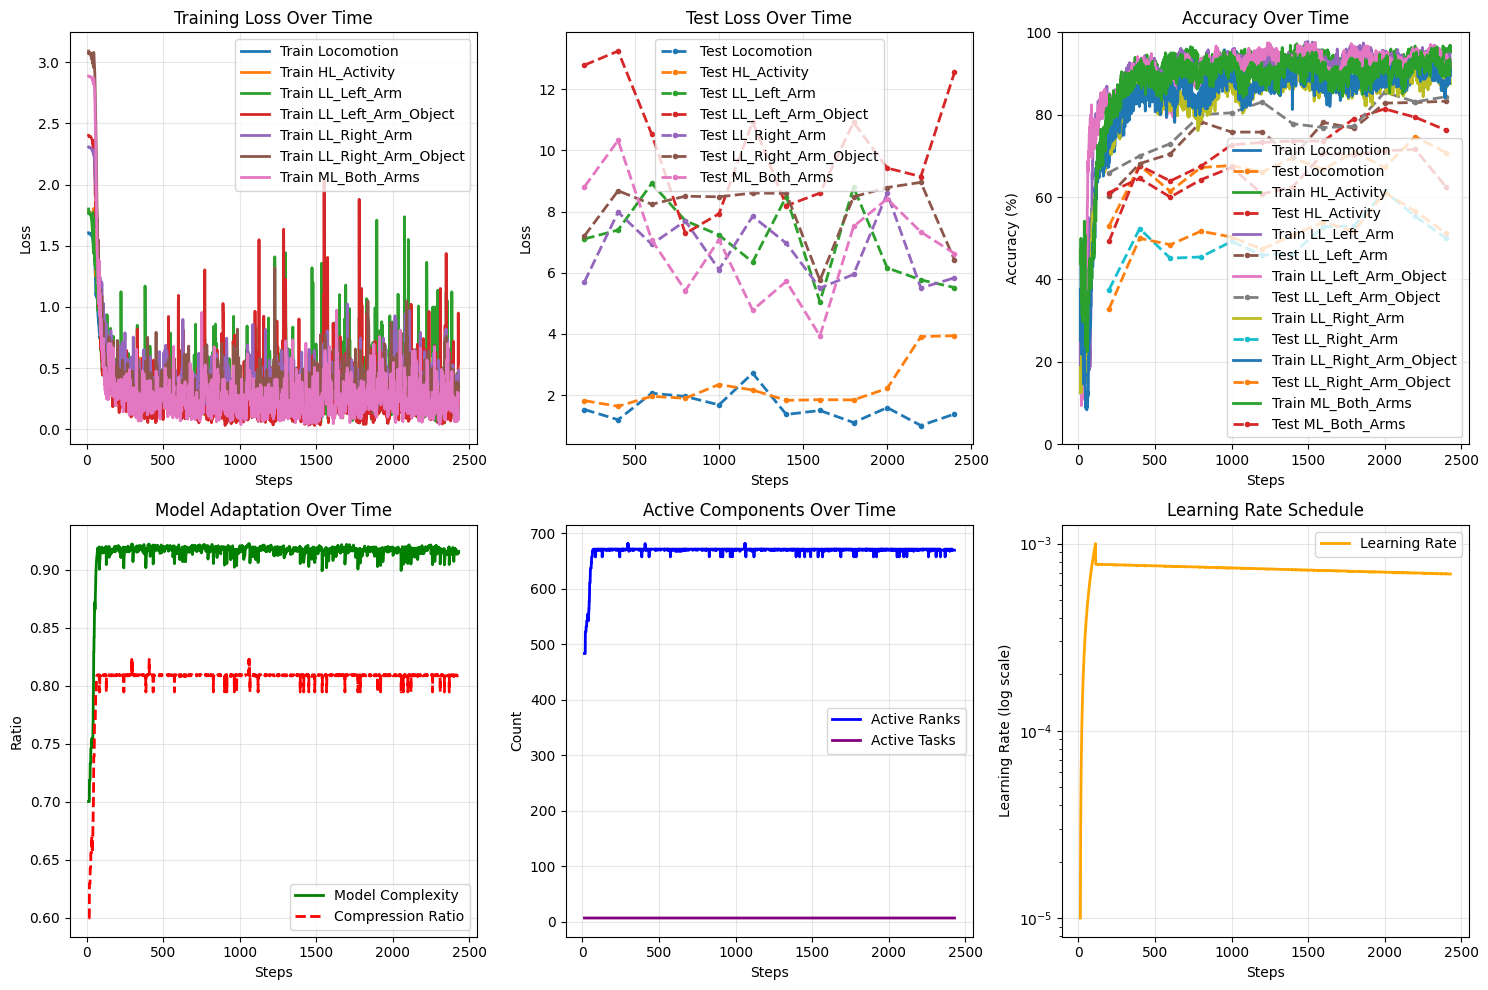

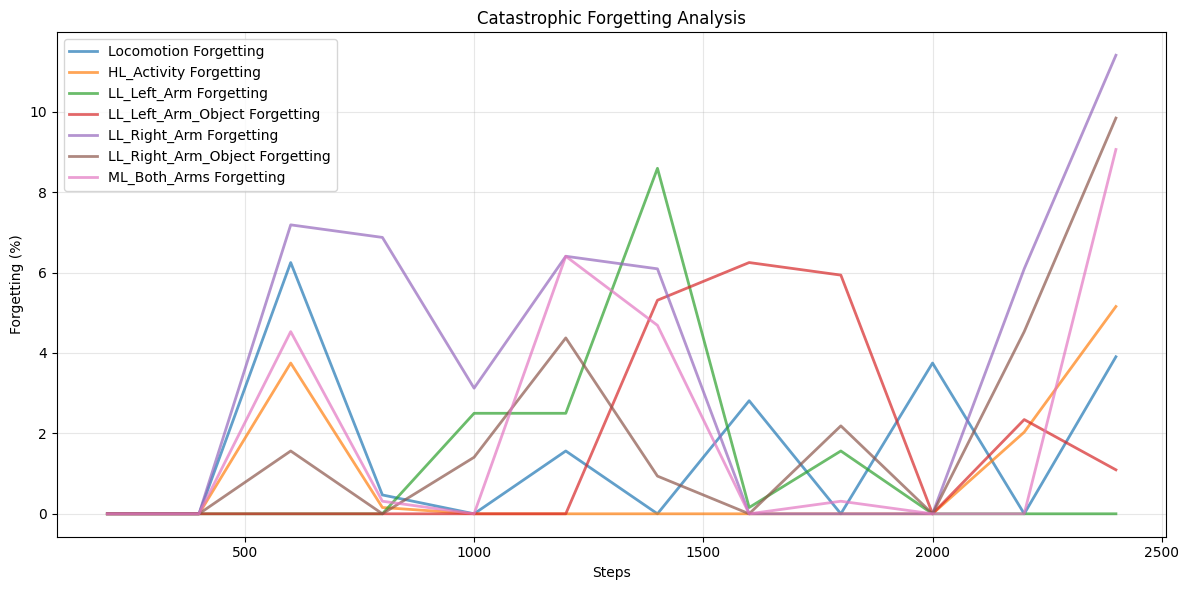

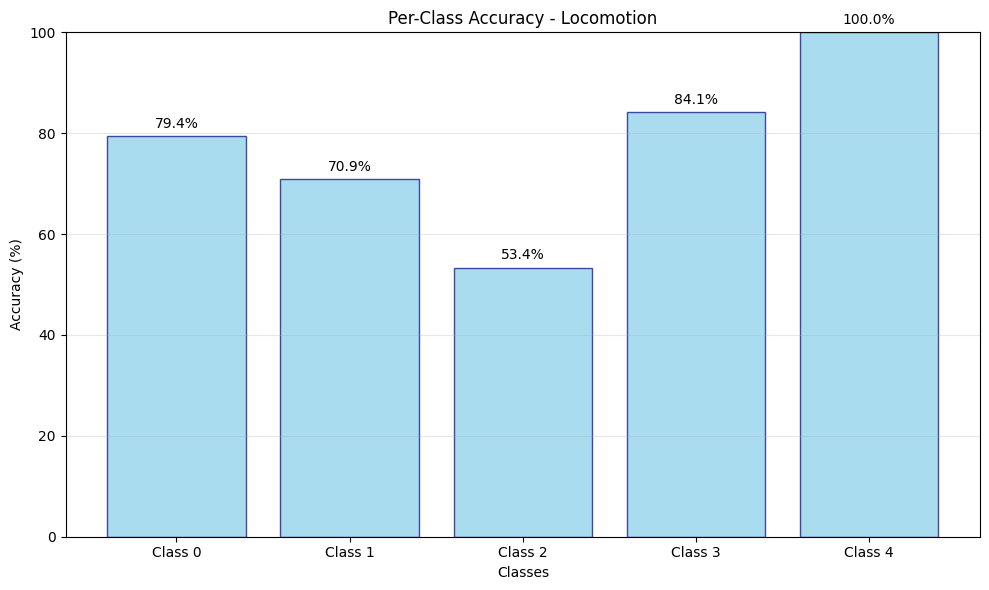


Classification Report - Locomotion:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.86      0.79      0.83       126
     Class 1       0.69      0.71      0.70       247
     Class 2       0.52      0.53      0.53       163
     Class 3       0.83      0.84      0.84        82
     Class 4       1.00      1.00      1.00        22

    accuracy                           0.71       640
   macro avg       0.78      0.78      0.78       640
weighted avg       0.71      0.71      0.71       640

--------------------------------------------------


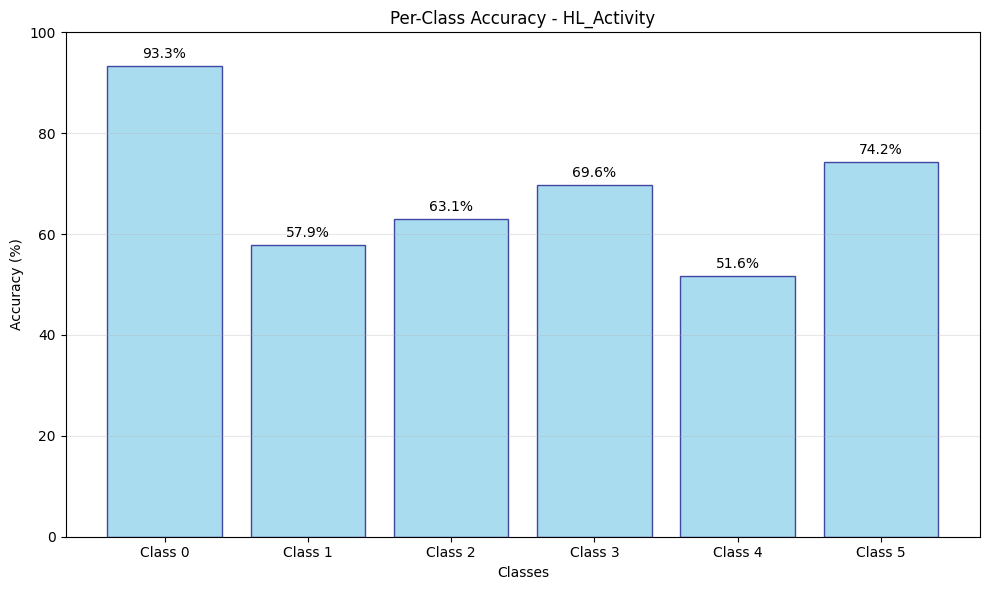


Classification Report - HL_Activity:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.78      0.93      0.85       239
     Class 1       1.00      0.58      0.73        38
     Class 2       0.63      0.63      0.63        65
     Class 3       0.74      0.70      0.72       112
     Class 4       0.62      0.52      0.56        62
     Class 5       0.84      0.74      0.79       124

    accuracy                           0.76       640
   macro avg       0.77      0.68      0.71       640
weighted avg       0.77      0.76      0.76       640

--------------------------------------------------


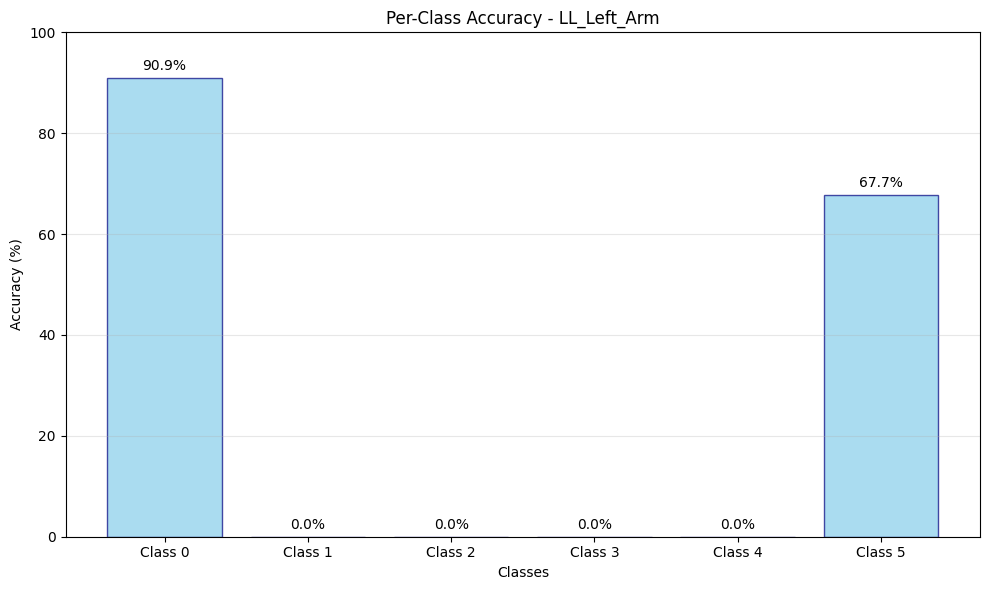


Classification Report - LL_Left_Arm:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.93      0.91      0.92       538
     Class 1       0.00      0.00      0.00        10
     Class 2       0.00      0.00      0.00        18
     Class 3       0.00      0.00      0.00         5
     Class 4       0.00      0.00      0.00         4
     Class 5       0.51      0.68      0.58        65

    accuracy                           0.83       640
   macro avg       0.24      0.26      0.25       640
weighted avg       0.83      0.83      0.83       640

--------------------------------------------------


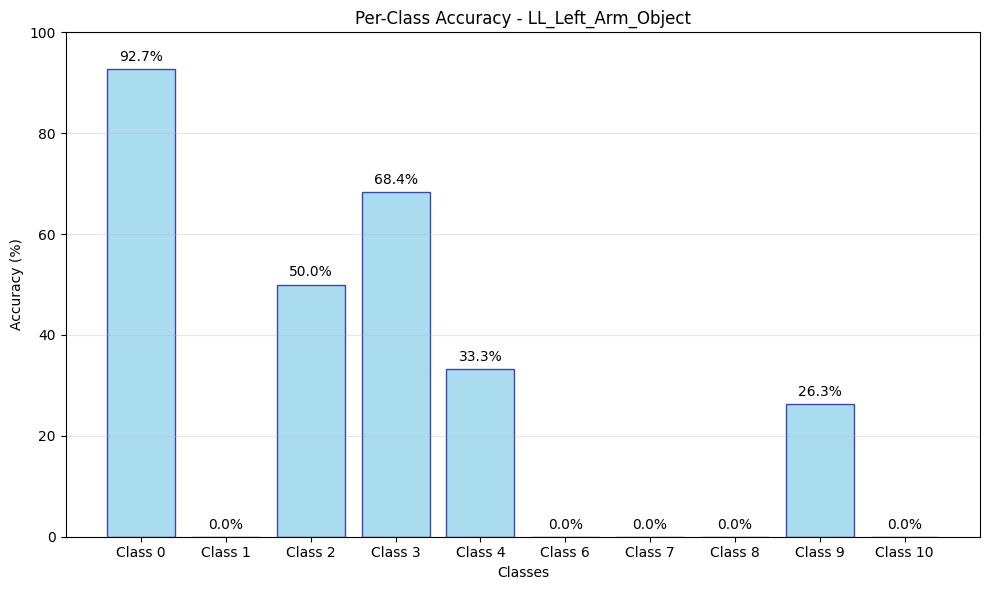


Classification Report - LL_Left_Arm_Object:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.91      0.93      0.92       549
     Class 1       0.00      0.00      0.00         3
     Class 2       0.73      0.50      0.59        22
     Class 3       0.37      0.68      0.48        19
     Class 4       0.29      0.33      0.31         6
     Class 6       0.00      0.00      0.00         1
     Class 7       0.00      0.00      0.00         6
     Class 8       0.00      0.00      0.00        12
     Class 9       0.36      0.26      0.30        19
    Class 10       0.00      0.00      0.00         3

    accuracy                           0.84       640
   macro avg       0.27      0.27      0.26       640
weighted avg       0.83      0.84      0.83       640

--------------------------------------------------


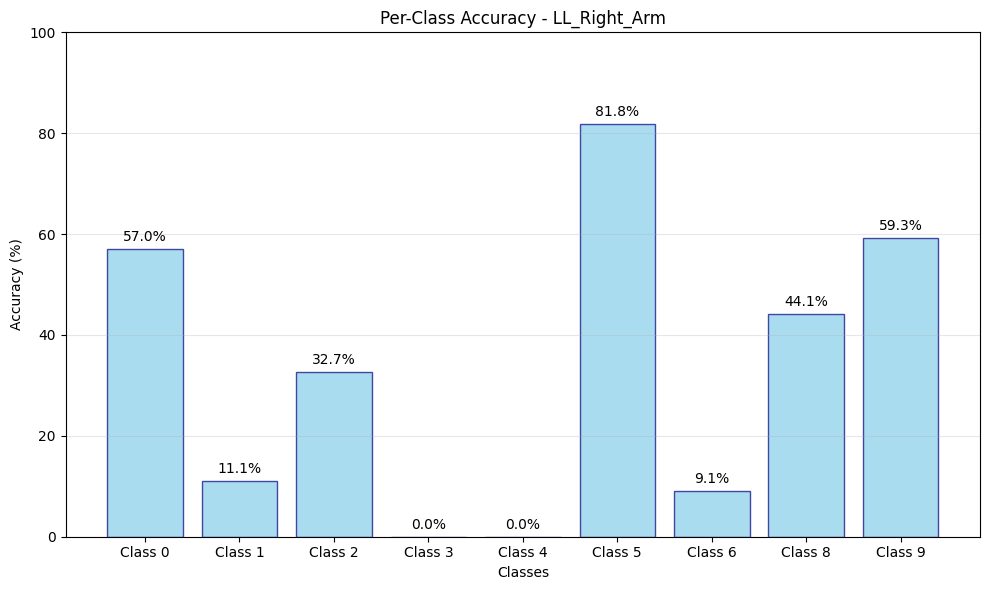


Classification Report - LL_Right_Arm:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.77      0.57      0.66       377
     Class 1       0.07      0.11      0.09        18
     Class 2       0.21      0.33      0.26        55
     Class 3       0.00      0.00      0.00        25
     Class 4       0.00      0.00      0.00        12
     Class 5       0.82      0.82      0.82        22
     Class 6       0.17      0.09      0.12        11
     Class 7       0.00      0.00      0.00         0
     Class 8       0.23      0.44      0.30        34
     Class 9       0.37      0.59      0.45        86

    accuracy                           0.50       640
   macro avg       0.26      0.30      0.27       640
weighted avg       0.57      0.50      0.52       640

--------------------------------------------------


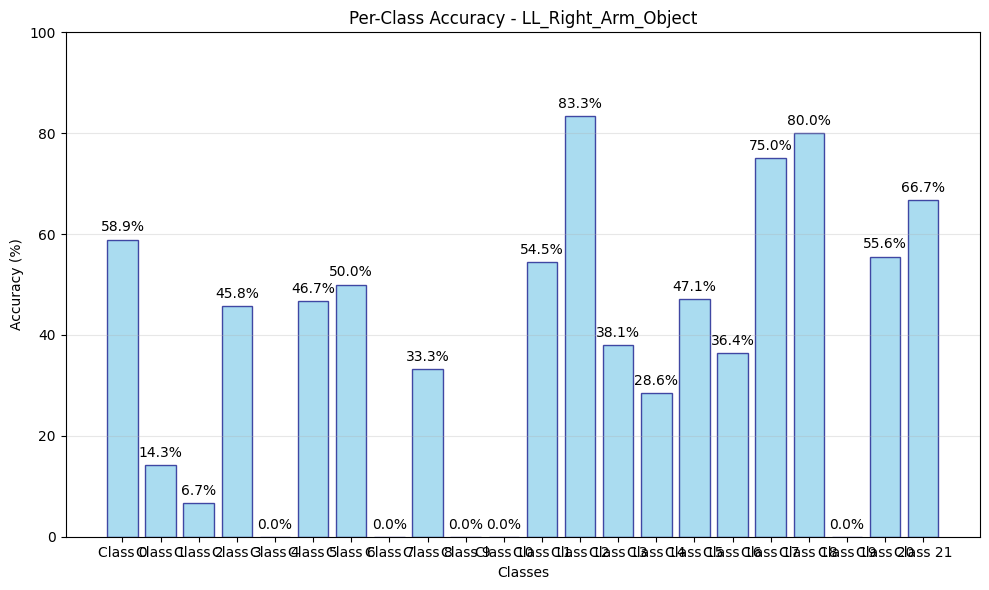


Classification Report - LL_Right_Arm_Object:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.75      0.59      0.66       370
     Class 1       0.50      0.14      0.22        14
     Class 2       0.25      0.07      0.11        15
     Class 3       0.39      0.46      0.42        24
     Class 4       0.00      0.00      0.00         6
     Class 5       0.19      0.47      0.27        15
     Class 6       0.33      0.50      0.40         6
     Class 7       0.00      0.00      0.00        12
     Class 8       0.40      0.33      0.36         6
     Class 9       0.00      0.00      0.00         4
    Class 10       0.00      0.00      0.00         8
    Class 11       0.67      0.55      0.60        22
    Class 12       0.77      0.83      0.80        24
    Class 13       0.21      0.38      0.27        21
    Class 14       0.17      0.29      0.21         7
    Class 15       0.31      0.47     

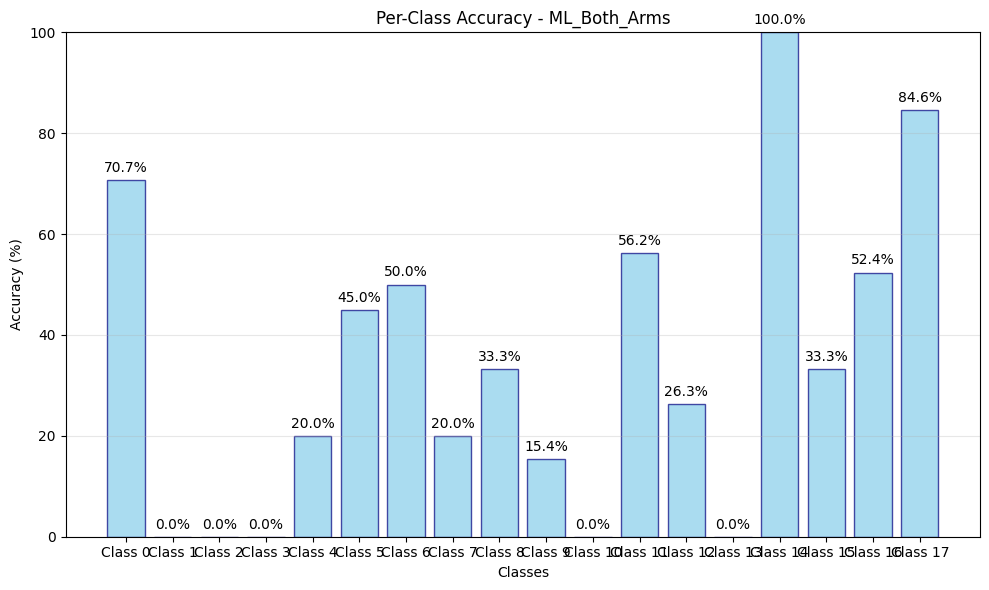


Classification Report - ML_Both_Arms:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.89      0.71      0.79       467
     Class 1       0.00      0.00      0.00         2
     Class 2       0.00      0.00      0.00         4
     Class 3       0.00      0.00      0.00         8
     Class 4       0.05      0.20      0.07         5
     Class 5       0.53      0.45      0.49        20
     Class 6       0.14      0.50      0.22         4
     Class 7       0.29      0.20      0.24        10
     Class 8       0.07      0.33      0.11         6
     Class 9       0.20      0.15      0.17        13
    Class 10       0.00      0.00      0.00         2
    Class 11       0.60      0.56      0.58        16
    Class 12       0.36      0.26      0.30        19
    Class 13       0.00      0.00      0.00         4
    Class 14       0.11      1.00      0.20         1
    Class 15       0.40      0.33      0.36  

In [7]:
# First, convert your labels to mapped indices for training
train_labels_dict = {}
test_labels_dict = {}
for i, track in enumerate(label_tracks):
    train_labels_dict[track] = torch.from_numpy(train_y[:, i])
    test_labels_dict[track] = torch.from_numpy(test_y[:, i])

# Convert to mapped indices (0-based) for training
mapped_train_labels = model.map_labels_to_indices(train_labels_dict)
mapped_test_labels = model.map_labels_to_indices(test_labels_dict)

# Keep tensors (no .numpy())
mapped_train_y = {
    track: mapped_train_labels[track]
    for track in label_tracks
}
mapped_test_y = {
    track: mapped_test_labels[track]
    for track in label_tracks
}

# MODIFIED: Call with new streaming parameters
# Simple call - uses defaults (LightSpaN-like behavior)
metrics_tracker, final_stats = train_tinytl_adaptive(
    model,
    train_X_mod,
    mapped_train_y,
    test_X_mod=test_X_mod,
    test_y_dict=mapped_test_y,
    total_steps=total_steps,
    base_lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu",
    window_size=100,
    batch_size=32,
    stream_rate=5,
    print_every=25,
    eval_every=200,
    patience=total_steps,
    complexity_adaptation=True,
    transfer_learning=True
)

print("Training finished ✅")
print("Final stats:", final_stats)

In [8]:
print(type(train_y))
print(type(test_y))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
def unified_model_stats(model, count_dense_as_active=False):
    """
    Returns a normalized stats dict with keys:
      total_parameters, active_parameters, current_sparsity,
      estimated_flops, memory_full_mb, memory_active_mb,
      active_tasks, active_attention_heads
    Prefers the model's own get_model_stats(); falls back safely.
    """
    base = {}
    if hasattr(model, "get_model_stats"):
        try:
            base = model.get_model_stats() or {}
        except Exception:
            base = {}

    # 1) Pull from model's stats if available
    total_params = base.get("total_parameters", base.get("total_params"))
    active_params = base.get("active_parameters", base.get("active_params"))
    eff_sparsity = base.get("current_sparsity", base.get("effective_sparsity"))
    est_flops = base.get("estimated_flops")

    # 2) Fallbacks
    if total_params is None:
        total_params = sum(p.numel() for p in model.parameters())

    if active_params is None:
        # Sum masks for DynamicSparseLinear
        active_params = 0
        for m in model.modules():
            if m.__class__.__name__ == "DynamicSparseLinear":
                # mask has same shape as weight
                active_params += int(getattr(m, "mask").sum().item())
            elif count_dense_as_active:
                # Optionally treat non-sparse layers as fully active
                for p in m.parameters(recurse=False):
                    active_params += p.numel()

    if eff_sparsity is None:
        eff_sparsity = 1.0 - (active_params / max(1, total_params))

    if est_flops is None:
        # Reasonable proxy when not provided
        est_flops = active_params

    # 3) Memory estimates using actual dtype size
    try:
        elem_size = next(model.parameters()).element_size()
    except StopIteration:
        elem_size = 4  # default to float32
    memory_full_mb = total_params * elem_size / (1024**2)
    memory_active_mb = active_params * elem_size / (1024**2)

    # 4) Extras
    active_tasks = base.get("active_tasks", getattr(getattr(model, "classifier", None), "active_tasks", None))
    active_attention_heads = base.get("active_attention_heads", getattr(getattr(model, "fusion", None), "active_heads", None))

    return {
        "total_parameters": int(total_params),
        "active_parameters": int(active_params),
        "current_sparsity": float(eff_sparsity),
        "estimated_flops": float(est_flops),
        "memory_full_mb": float(memory_full_mb),
        "memory_active_mb": float(memory_active_mb),
        "active_tasks": active_tasks,
        "active_attention_heads": active_attention_heads,
    }

In [10]:


stats = unified_model_stats(model)  # default: counts only masked params as active

print(f"Total parameters: {stats['total_parameters']}")
print(f"Active parameters: {stats['active_parameters']}")
print(f"Sparsity: {stats['current_sparsity']:.4f}")
print(f"Estimated FLOPs: {stats['estimated_flops']}")
print(f"Memory (full): {stats['memory_full_mb']:.2f} MB")
print(f"Memory (active): {stats['memory_active_mb']:.2f} MB")
print(f"Active tasks: {stats['active_tasks']}")
print(f"Active attention heads: {stats['active_attention_heads']}")



Total parameters: 236574
Active parameters: 0
Sparsity: 1.0000
Estimated FLOPs: 0.0
Memory (full): 0.90 MB
Memory (active): 0.00 MB
Active tasks: 7
Active attention heads: None


In [11]:
import torch
import json

def save_adaptive_model(model: TinyTL, 
                        filepath_prefix: str = "tinyTL_model"):
    """
    Saves the model state_dict, sparsity masks, and stats to disk.
    """
    # 1️⃣ Save model state_dict
    torch.save(model.state_dict(), f"{filepath_prefix}_state.pth")
    
    # 2️⃣ Save model stats (total params, active params, sparsity, etc.)
    stats = model.get_model_stats()
    with open(f"{filepath_prefix}_stats.json", "w") as f:
        json.dump(stats, f, indent=4)
    
    print(f"✅ Model saved successfully:\n- Weights: {filepath_prefix}_state.pth\n- Stats: {filepath_prefix}_stats.json")

save_adaptive_model(model)



✅ Model saved successfully:
- Weights: tinyTL_model_state.pth
- Stats: tinyTL_model_stats.json
